In [1]:
# conda update statsmodels

# Projet_P9 : Prédisez la demande en électricité

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy import stats as st
from scipy.stats import pearsonr
%matplotlib inline
from pandas_profiling import ProfileReport
import warnings
warnings.filterwarnings('ignore')
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn import decomposition
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import KMeans
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from math import pi

## Téléchargement des données

### Données CEGIBAT (effet Chauffage éléctrique)

In [3]:
# téléchargement des fichiers extraits du site CEGIBAT 
''' Extraction des données "chauffage" pour une Tref=18°C
     Choix d'1 ville par région puis
     Moyenne nationale après traitement '''
    
path = 'C:\\Users\\HP\\INPUTS_FORMATION'
files = [file for file in os.listdir(path) if file.endswith(".xlsx")]

print ("Les fichiers téléchargés depuis CEGIBAT sont :")
for i in files :
    print (i)
    
# initialisation d'un dataframe
df = pd.DataFrame()

# concaténation des fichiers
for f in files:
    data = pd.read_excel(f, 'DJU - Mensuel')
    data = data.iloc[10:]
    df   = df.append(data)

# set 1ère ligne comme header
df.columns = df.iloc[0]
df = df[1:]
df.rename(columns={df.columns[0]:'Year'}, inplace=True)

# conversion numérique
cols     = df.columns[df.dtypes.eq('object')]
df[cols] = df[cols].apply(pd.to_numeric, errors='coerce')

# suppression des lignes intermédiaires contenant que des NAN
df = df.dropna()

# calcul de la moyenne nationale (Moy(H1x,H2x,H3)) pour la suite de l'étude
f = {'JAN':'mean', 'FÉV':'mean', 'MAR':'mean', 'AVR':'mean', 'MAI':'mean', 'JUN':'mean', 'JUI':'mean', 'AOÛ':'mean', 
     'SEP':'mean', 'OCT':'mean', 'NOV':'mean', 'DÉC':'mean', 'Total':'mean'}
df = df.groupby(['Year']).agg(f)
df.head()

Les fichiers téléchargés depuis CEGIBAT sont :
P9_calcul_DJU_03_09_2021_1.xlsx
P9_calcul_DJU_03_09_2021_2.xlsx
P9_calcul_DJU_03_09_2021_3.xlsx
P9_calcul_DJU_03_09_2021_4.xlsx
P9_calcul_DJU_03_09_2021_5.xlsx
P9_calcul_DJU_03_09_2021_6.xlsx
P9_calcul_DJU_03_09_2021_7.xlsx
P9_calcul_DJU_03_09_2021_8.xlsx


10,JAN,FÉV,MAR,AVR,MAI,JUN,JUI,AOÛ,SEP,OCT,NOV,DÉC,Total
Year,,,,,,,,,,,,,
2009.0,456.2125,348.9875,287.2875,162.9000,65.8875,24.2875,5.9875,4.1375,27.4375,139.5625,210.4750,385.2750,2118.1750
2010.0,478.3500,359.0250,307.0125,172.0625,128.2125,23.6625,1.0500,13.8750,58.3750,165.0000,286.1375,464.2250,2456.7250
2011.0,395.0875,302.1125,258.8000,103.1625,51.3750,30.2250,17.6500,11.7375,23.0000,116.3000,205.0250,309.8000,1823.9875
2012.0,350.7000,455.8125,224.9750,210.6500,83.1500,26.9250,13.9500,3.4875,48.2375,127.8125,258.9750,336.6375,2141.0375
2013.0,406.8000,388.7000,327.0250,206.9875,153.1250,40.7250,1.3875,4.7750,33.9625,85.8750,289.6375,354.8625,2293.6875


In [4]:
# pivot
stacked = df.stack()
stacked = pd.DataFrame(data=stacked)

# superposition
stacked.rename(columns={stacked.columns[0]:'DJU_effet_T'}, inplace=True)
df = stacked.reset_index()
df
# renaming & conversion
df.rename(columns={10:'Month'}, inplace=True)
df
di = {'JAN':1, 'FÉV':2, 'MAR':3, 'AVR':4, 'MAI':5, 'JUN':6, 'JUI':7, 'AOÛ':8, 'SEP':9, 'OCT':10, 'NOV':11, 'DÉC':12,}
df['Month'].replace(di, inplace=True)
df['Year'] = df['Year'].astype('int64')
df_DJU = df.copy()
df_DJU.head()

,Year,Month,DJU_effet_T
0,2009,1,456.2125
1,2009,2,348.9875
2,2009,3,287.2875
3,2009,4,162.9000
4,2009,5,65.8875


### Données Rte-France (Réseau de Transport d'Electricité)

In [5]:
# téléchargement des données NRJ
url  = 'INPUTS_FORMATION/P9_eCO2mix_RTE_energie_M.csv'
table   = pd.read_csv(url, sep=';',encoding='ANSI')
table.head()

,Mois,Qualité,Territoire,Production totale,Production nucléaire,Production thermique totale,Production thermique charbon,Production thermique fioul,Production thermique gaz,Production hydraulique,...,Production bioénergies,Consommation totale,Solde exportateur,Echanges export,Echanges import,Echanges avec le Royaume-Uni,Echanges avec l'Espagne,Echanges avec l'Italie,Echanges avec la Suisse,Echanges avec l'Allemagne et la Belgique
0,2012-01,Données définitives,France,57177,42811.0,5399,741.0,691,3967,6741,...,514,51086,5371.0,7043.0,1672.0,929.0,724.0,1581.0,2195.0,-59.0
1,2012-02,Données définitives,France,54419,38661.0,8721,2511.0,1309,4901,5244,...,454,54476,-715.0,4504.0,5220.0,-798.0,-309.0,1244.0,1579.0,-2430.0
2,2012-03,Données définitives,France,48583,37549.0,5276,1435.0,666,3175,3894,...,531,43156,4888.0,7042.0,2153.0,583.0,330.0,1742.0,2235.0,-1.0
3,2012-04,Données définitives,France,44192,33100.0,3484,1655.0,486,1343,5302,...,405,40176,3447.0,5762.0,2314.0,547.0,-9.0,1271.0,1670.0,-31.0
4,2012-05,Données définitives,France,40433,29058.0,1772,854.0,368,549,7706,...,469,35257,4425.0,6391.0,1965.0,693.0,251.0,1341.0,1060.0,1079.0


In [6]:
# prof = ProfileReport(table)
# prof.to_file(output_file='rapport_table_P9.html')

In [7]:
# table.describe(include='all')

## Traitements

In [8]:
# conversion [Mois] en datetime 
table['Mois']  = pd.to_datetime(table['Mois']) 
table_origine = table.copy()

# création [Année]
table.insert(1, "Year", table['Mois'].dt.year, allow_duplicates=False)
table.insert(2, "Month", table['Mois'].dt.month, allow_duplicates=False)
table.rename(columns={'Mois':'Date'}, inplace=True)
table.drop(columns=["Qualité"], inplace=True)
table_init = table.copy()
# table.to_csv("OUTPUTS_FORMATION/P9_add_année.csv", index = True)
# plt.figure(figsize=(15,5))
# sns.heatmap(table_init.isna(), cbar=False)

## Quelques visualisations

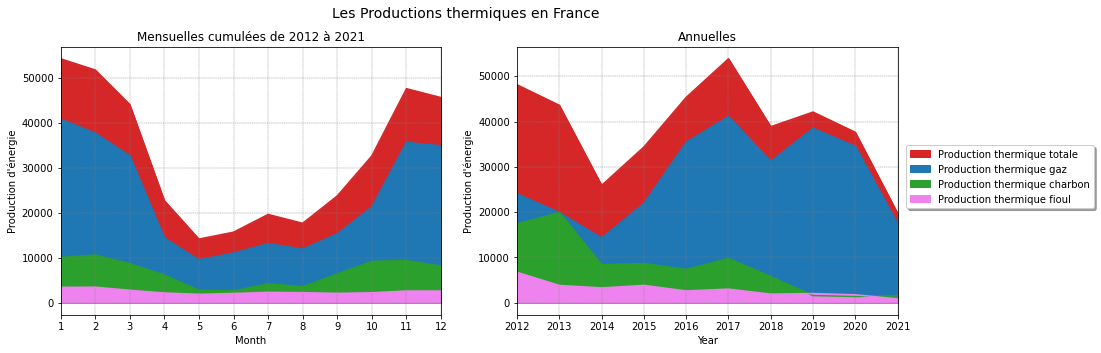

In [9]:
plt.figure(figsize=(15,5))
plt.suptitle('Les Productions thermiques en France',fontsize=14)
# plt.tight_layout()
plt.subplots_adjust(top=.87)
plt.subplot(1, 2, 1)
table = table_init.loc[table_init["Territoire"]=="France"]
table = table.groupby(['Month']).agg({'Production thermique totale':'sum',
                                     'Production thermique charbon':'sum',
                                     'Production thermique fioul':'sum',
                                     'Production thermique gaz':'sum'})
plt.rcParams.update({'figure.figsize':(8,6), 'figure.dpi':100})
sns.lineplot(data=table, x=table.index, y="Production thermique totale" , ci= None, color ='tab:red')
plt.fill_between(table.index.values, table["Production thermique totale"].values, color ='tab:red')
sns.lineplot(data=table, x=table.index, y="Production thermique gaz"    , ci= None, color ='tab:blue')
plt.fill_between(table.index.values, table["Production thermique gaz"].values, color ='tab:blue')
sns.lineplot(data=table, x=table.index, y="Production thermique charbon", ci= None, color ='tab:green')
plt.fill_between(table.index.values, table["Production thermique charbon"].values, color ='tab:green')
sns.lineplot(data=table, x=table.index, y="Production thermique fioul"  , ci= None, color ='violet') 
plt.fill_between(table.index.values, table["Production thermique fioul"].values, color ='violet')

plt.title('Mensuelles cumulées de '+str(table_init["Year"].min())+' à '+str(table_init["Year"].max()))

my_colors = {
            table.columns[0]:'tab:red',table.columns[3]:'tab:blue',
            table.columns[1]:'tab:green',table.columns[2]:'violet',                       
            }          
lab_col = list(my_colors.keys())
handles = [plt.Rectangle((0,0),0,0, color=my_colors[label]) for label in lab_col]              
# plt.legend(handles, lab_col, ncol=1, shadow=True, loc='best',fontsize=7.5)

plt.xticks(range(1, 13,1))
plt.xlim(1, 12)
plt.ylabel("Production d'énergie")
plt.grid(color='gray', linestyle='--', linewidth=0.4)
# plt.yscale('log')

plt.subplot(1, 2, 2)
table = table_init.loc[table_init["Territoire"]=="France"]
table = table.groupby(['Year']).agg({'Production thermique totale':'sum',
                                     'Production thermique charbon':'sum',
                                     'Production thermique fioul':'sum',
                                     'Production thermique gaz':'sum'})
plt.rcParams.update({'figure.figsize':(8,6), 'figure.dpi':100})
sns.lineplot(data=table, x=table.index, y="Production thermique totale" , ci= None, color ='tab:red')
plt.fill_between(table.index.values, table["Production thermique totale"].values, color ='tab:red')
sns.lineplot(data=table, x=table.index, y="Production thermique gaz"    , ci= None, color ='tab:blue')
plt.fill_between(table.index.values, table["Production thermique gaz"].values, color ='tab:blue')
sns.lineplot(data=table, x=table.index, y="Production thermique charbon", ci= None, color ='tab:green')
plt.fill_between(table.index.values, table["Production thermique charbon"].values, color ='tab:green')
sns.lineplot(data=table, x=table.index, y="Production thermique fioul"  , ci= None, color ='violet') 
plt.fill_between(table.index.values, table["Production thermique fioul"].values, color ='violet')

plt.title('Annuelles')        
plt.legend(handles, lab_col, ncol=1, shadow=True, loc='best',fontsize=10, bbox_to_anchor=(1.01, .65))

plt.xticks(range(2012, 2022,1))
plt.xlim(2012, 2021)
plt.ylabel("Production d'énergie")
plt.grid(color='gray', linestyle='--', linewidth=0.4)
# plt.yscale('log')

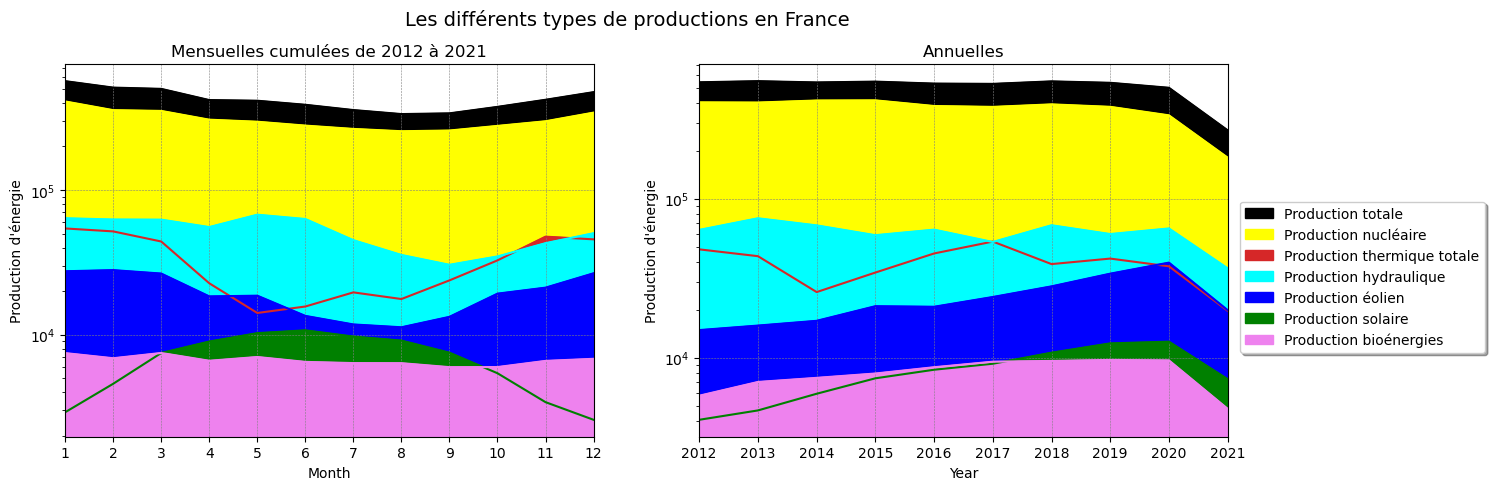

In [10]:
plt.figure(figsize=(15,5))
plt.suptitle('Les différents types de productions en France',fontsize=14)
# plt.tight_layout()
plt.subplots_adjust(top=.87)
plt.subplot(1, 2, 1)
table = table_init.loc[table_init["Territoire"]=="France"]
table = table.groupby(['Month']).agg({'Production totale':'sum',
                                          'Production nucléaire':'sum',
                                              'Production thermique totale':'sum',
                                              'Production thermique charbon':'sum',
                                              'Production thermique fioul':'sum',
                                              'Production thermique gaz':'sum',
                                        'Production hydraulique':'sum',
                                        'Production éolien':'sum',
                                        'Production solaire':'sum',
                                        'Production bioénergies':'sum',
                                     })
sns.lineplot(data=table, x=table.index, y="Production totale" , ci= None, color ='k')
plt.fill_between(table.index.values, table["Production totale"].values, color ='k')
sns.lineplot(data=table, x=table.index, y="Production nucléaire" , ci= None, color ='yellow')
plt.fill_between(table.index.values, table["Production nucléaire"].values, color ='yellow')
sns.lineplot(data=table, x=table.index, y="Production thermique totale" , ci= None, color ='tab:red')
plt.fill_between(table.index.values, table["Production thermique totale"].values, color ='tab:red')
sns.lineplot(data=table, x=table.index, y="Production hydraulique" , ci= None, color ='cyan')
plt.fill_between(table.index.values, table["Production hydraulique"].values, color ='cyan')
sns.lineplot(data=table, x=table.index, y="Production éolien"    , ci= None, color ='blue')
plt.fill_between(table.index.values, table["Production éolien"].values, color ='blue')
sns.lineplot(data=table, x=table.index, y="Production solaire", ci= None, color ='green')
plt.fill_between(table.index.values, table["Production solaire"].values, color ='green')
sns.lineplot(data=table, x=table.index, y="Production bioénergies"  , ci= None, color ='violet') 
plt.fill_between(table.index.values, table["Production bioénergies"].values, color ='violet')

plt.title('Mensuelles cumulées de '+str(table_init["Year"].min())+' à '+str(table_init["Year"].max()))
plt.xticks(range(1, 13,1))
plt.xlim(1, 12)
plt.ylabel("Production d'énergie")
plt.grid(color='gray', linestyle='--', linewidth=0.4)
plt.yscale('log')

plt.subplot(1, 2, 2)
table = table_init.loc[table_init["Territoire"]=="France"]
table = table.groupby(['Year']).agg({'Production totale':'sum',
                                          'Production nucléaire':'sum',
                                              'Production thermique totale':'sum',
                                              'Production thermique charbon':'sum',
                                              'Production thermique fioul':'sum',
                                              'Production thermique gaz':'sum',
                                        'Production hydraulique':'sum',
                                        'Production éolien':'sum',
                                        'Production solaire':'sum',
                                        'Production bioénergies':'sum',
                                     })
sns.lineplot(data=table, x=table.index, y="Production totale" , ci= None, color ='k')
plt.fill_between(table.index.values, table["Production totale"].values, color ='k')
sns.lineplot(data=table, x=table.index, y="Production nucléaire" , ci= None, color ='yellow')
plt.fill_between(table.index.values, table["Production nucléaire"].values, color ='yellow')
sns.lineplot(data=table, x=table.index, y="Production thermique totale" , ci= None, color ='tab:red')
plt.fill_between(table.index.values, table["Production thermique totale"].values, color ='tab:red')
sns.lineplot(data=table, x=table.index, y="Production hydraulique" , ci= None, color ='cyan')
plt.fill_between(table.index.values, table["Production hydraulique"].values, color ='cyan')
sns.lineplot(data=table, x=table.index, y="Production éolien"    , ci= None, color ='blue')
plt.fill_between(table.index.values, table["Production éolien"].values, color ='blue')
sns.lineplot(data=table, x=table.index, y="Production solaire", ci= None, color ='green')
plt.fill_between(table.index.values, table["Production solaire"].values, color ='green')
sns.lineplot(data=table, x=table.index, y="Production bioénergies"  , ci= None, color ='violet') 
plt.fill_between(table.index.values, table["Production bioénergies"].values, color ='violet')

plt.title('Annuelles')
my_colors = {table.columns[0]:'k',table.columns[1]:'yellow',table.columns[2]:'tab:red',table.columns[6]:'cyan',
             table.columns[7]:'blue',table.columns[8]:'green',table.columns[9]:'violet'}          
lab_col = list(my_colors.keys())
handles = [plt.Rectangle((0,0),0,0, color=my_colors[label]) for label in lab_col]              
plt.legend(handles, lab_col, ncol=1, shadow=True, loc='best',fontsize=10, bbox_to_anchor=(1.01, .65))
plt.xticks(range(2012, 2022,1))
plt.xlim(2012, 2021)
plt.ylabel("Production d'énergie")
plt.grid(color='gray', linestyle='--', linewidth=0.4)
plt.yscale('log')

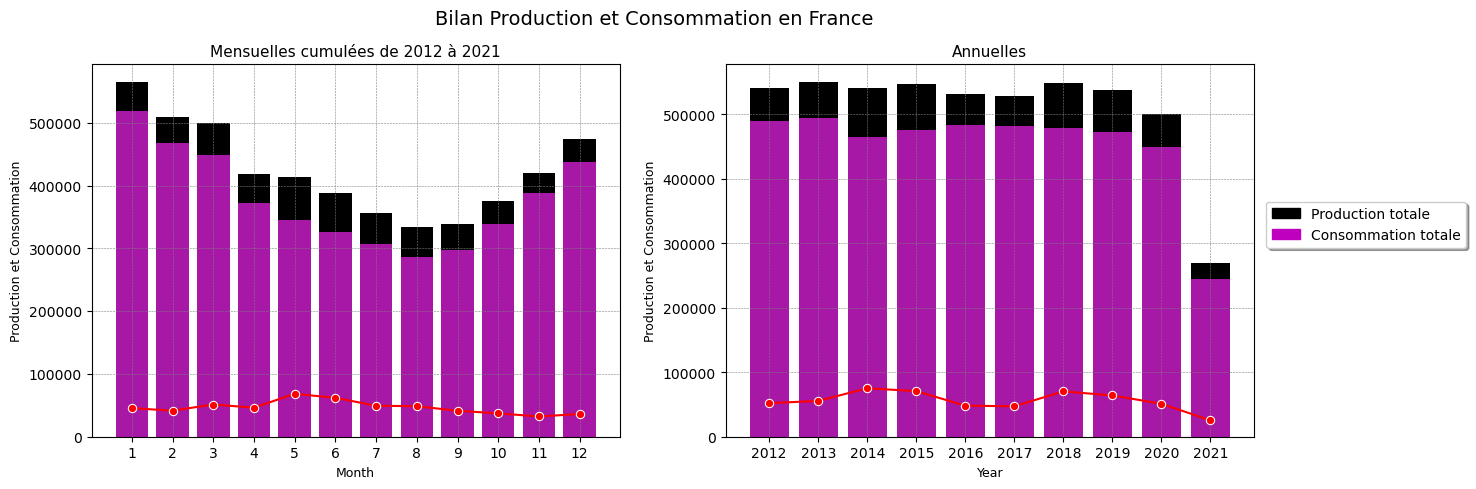

In [11]:
plt.figure(figsize=(15,5))
plt.suptitle('Bilan Production et Consommation en France',fontsize=14)
# plt.tight_layout()
plt.subplots_adjust(top=.87)
plt.subplot(1, 2, 1)
table = table_init.loc[table_init["Territoire"]=="France"]
table_m = table.groupby(['Month']).agg({'Production totale':'sum','Consommation totale':'sum'})
sns.barplot(data=table_m, x=table_m.index, y="Production totale" , color ='k')
sns.barplot(data=table_m, x=table_m.index, y="Consommation totale" , color ='m')
for j, row in table_m.iterrows():
    table_m.loc[j,'Delta'] = row['Production totale']- row["Consommation totale"]
sns.lineplot(data=table_m, x=table_m.index-1, y="Delta" , ci= None, color ='r', marker = "o")
plt.grid(color='gray', linestyle='--', linewidth=0.4)
plt.title('Mensuelles cumulées de '+str(table_init["Year"].min())+' à '+str(table_init["Year"].max()),fontsize=11)
plt.xlabel("Month",fontsize=9)
plt.ylabel("Production et Consommation",fontsize=9)
# plt.gca().get_yaxis().get_major_formatter().set_scientific(True)
plt.subplot(1, 2, 2)
table = table_init.loc[table_init["Territoire"]=="France"]
table_y = table.groupby(['Year']).agg({'Production totale':'sum','Consommation totale':'sum'})
sns.barplot(data=table_y, x=table_y.index, y="Production totale" , color ='k')
sns.barplot(data=table_y, x=table_y.index, y="Consommation totale" , color ='m')
for j, row in table_y.iterrows():
    table_y.loc[j,'Delta'] = row['Production totale']- row["Consommation totale"]
sns.lineplot(data=table_y, x=table_y.index-2012, y="Delta" , ci= None, color ='r', marker = "o")
plt.grid(color='gray', linestyle='--', linewidth=0.4)
plt.title('Annuelles',fontsize=11)
plt.xlabel("Year",fontsize=9)
plt.ylabel("Production et Consommation",fontsize=9)
my_colors = {table_m.columns[0]:'k',table_m.columns[1]:'m'}          
lab_col = list(my_colors.keys())
handles = [plt.Rectangle((0,0),0,0, color=my_colors[label]) for label in lab_col]              
plt.legend(handles, lab_col, ncol=1, shadow=True, loc='best',fontsize=10, bbox_to_anchor=(1.01, .65))
plt.savefig('OUTPUTS_FORMATION/P9_0_enjeu_prod_conso.jpg',dpi=300)
plt.show()

## Jointure DJU au df

In [12]:
Sample_final = pd.merge(table, df_DJU, how="left", on=['Year','Month'])
Sample_final.head()

,Date,Year,Month,Territoire,Production totale,Production nucléaire,Production thermique totale,Production thermique charbon,Production thermique fioul,Production thermique gaz,...,Consommation totale,Solde exportateur,Echanges export,Echanges import,Echanges avec le Royaume-Uni,Echanges avec l'Espagne,Echanges avec l'Italie,Echanges avec la Suisse,Echanges avec l'Allemagne et la Belgique,DJU_effet_T
0,2012-01-01,2012,1,France,57177,42811.0,5399,741.0,691,3967,...,51086,5371.0,7043.0,1672.0,929.0,724.0,1581.0,2195.0,-59.0,350.7000
1,2012-02-01,2012,2,France,54419,38661.0,8721,2511.0,1309,4901,...,54476,-715.0,4504.0,5220.0,-798.0,-309.0,1244.0,1579.0,-2430.0,455.8125
2,2012-03-01,2012,3,France,48583,37549.0,5276,1435.0,666,3175,...,43156,4888.0,7042.0,2153.0,583.0,330.0,1742.0,2235.0,-1.0,224.9750
3,2012-04-01,2012,4,France,44192,33100.0,3484,1655.0,486,1343,...,40176,3447.0,5762.0,2314.0,547.0,-9.0,1271.0,1670.0,-31.0,210.6500
4,2012-05-01,2012,5,France,40433,29058.0,1772,854.0,368,549,...,35257,4425.0,6391.0,1965.0,693.0,251.0,1341.0,1060.0,1079.0,83.1500


# MISSION 1 (Correction données de consommation de l'effet T)

### Seaborn : regplot

a : 50.35
b : 31319.71
y        = 50.35 x +  31319.71
Cons_TOT = 50.35 DJU_effet_T +  31319.71


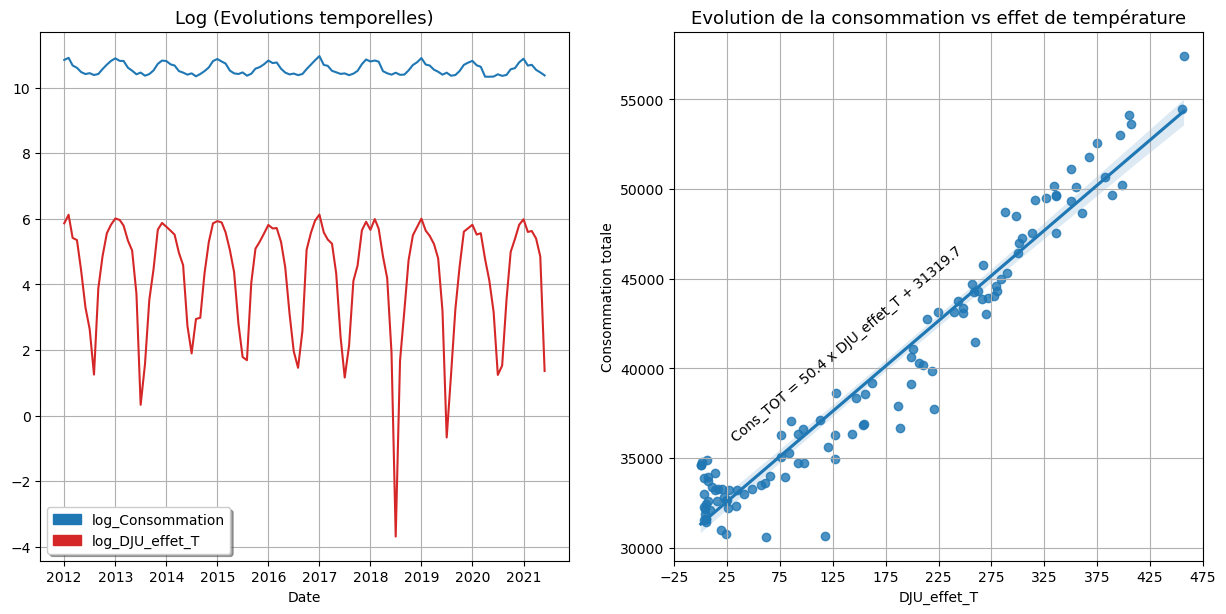

In [13]:
plt.subplots(figsize=(15,7))
# plt.suptitle("Corrélation", fontsize=16)
# plt.tight_layout()
# plt.subplots_adjust(top=0.88)
plt.subplot(1, 2, 1)
Sample_final["log_Consommation"] = np.log(Sample_final["Consommation totale"])
Sample_final["log_DJU_effet_T"] = np.log(Sample_final["DJU_effet_T"])
sns.lineplot(x="Date", y="log_Consommation", data=Sample_final, color ="tab:blue")
sns.lineplot(x="Date", y="log_DJU_effet_T", data=Sample_final, color ="tab:red")
plt.title("Log (Evolutions temporelles)",fontsize=13)
plt.ylabel("")
my_colors = {Sample_final.columns[24]:'tab:blue',Sample_final.columns[25]:'tab:red'}          
lab_col = list(my_colors.keys())
handles = [plt.Rectangle((0,0),0,0, color=my_colors[label]) for label in lab_col]              
plt.legend(handles, lab_col, ncol=1, shadow=True, loc='lower left',fontsize=10)
plt.grid()

plt.subplot(1, 2, 2)

corr = sns.regplot(x="DJU_effet_T", y="Consommation totale", data=Sample_final, color ="tab:blue")
slope, intercept, r_value, p_value, std_err = stats.linregress(x=corr.get_lines()[0].get_xdata(),
                                                               y=corr.get_lines()[0].get_ydata())

print('a :',round(slope,2))
print('b :',round(intercept,2))
print ('y        =', round(slope,2),'x + ', round(intercept,2))
print ('Cons_TOT =', round(slope,2),'DJU_effet_T + ', (round(intercept,2)))
plt.grid()
plt.ylabel('Consommation totale')
plt.title("Evolution de la consommation vs effet de température",fontsize=13)
plt.xticks(range(-25,500,50))
plt.annotate(('Cons_TOT = '+str(round(slope,1))+' x DJU_effet_T + '+str((round(intercept,1)))), xy=(50, 40000),  xycoords='data',
            xytext=(0.55, 0.6), textcoords='axes fraction',c='k',fontsize=10,rotation=40,
#             arrowprops=dict(facecolor='black', shrink=0.05),
            horizontalalignment='right', verticalalignment='top',
            )
plt.savefig('OUTPUTS_FORMATION/P9_1_correlation_DJU_conso.jpg',dpi=300)
plt.show()

### Statsmodels : régression linéaire

 Variance expliquée (with Adjusted R-square -> compare mdl with diff nb of indep var): 94.0 % 
                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.941
Model:                            OLS   Adj. R-squared:                  0.941
Method:                 Least Squares   F-statistic:                     1793.
Date:                Mon, 04 Oct 2021   Prob (F-statistic):           9.25e-71
Time:                        14:52:26   Log-Likelihood:                -1010.4
No. Observations:                 114   AIC:                             2025.
Df Residuals:                     112   BIC:                             2030.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------

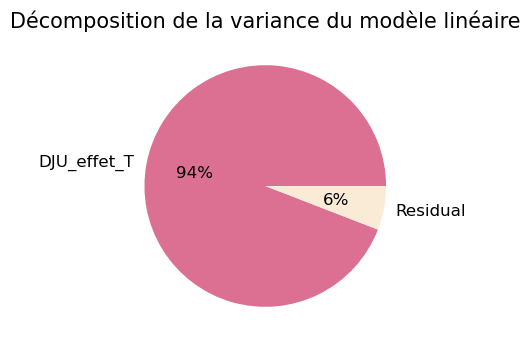

coef_DJU_T c = 50.4


In [14]:
Y = Sample_final["Consommation totale"]
DJU_effet_T = Sample_final["DJU_effet_T"]

# régression
model = ols('Y ~ DJU_effet_T', data=Sample_final).fit()
print('\x1b[6;32;40m',"Variance expliquée (with Adjusted R-square -> compare mdl with diff nb of indep var):", str(100*round(model.rsquared_adj,2)),"%",'\x1b[0m')
print(model.summary())

# décomposition variance 
plt.figure(figsize=(5,4))
aov_table = sm.stats.anova_lm(model, typ=2)
Sum_Sq  = aov_table['sum_sq'][0] + aov_table['sum_sq'][1] 
esq_sm1 = aov_table['sum_sq'][0]/Sum_Sq
esq_sm2 = aov_table['sum_sq'][1]/Sum_Sq
aov_table['EtaSq'] = [esq_sm1, esq_sm2]
print('')
print(aov_table)
mycolors = ['palevioletred','antiquewhite']
aov_table['EtaSq'].plot.pie(autopct='%1.f%%',fontsize=12,colors = mycolors)
plt.title("Décomposition de la variance du modèle linéaire",fontsize=15)
plt.ylabel('')
# plt.savefig('OUTPUTS_FORMATION/P9_décomposition_Variance_mdl.jpg',dpi=300)
plt.show()

# lecture du coefficient 
c = round((model.params[1]),1)
print('coef_DJU_T c = ' + str(round((model.params[1]),1)))

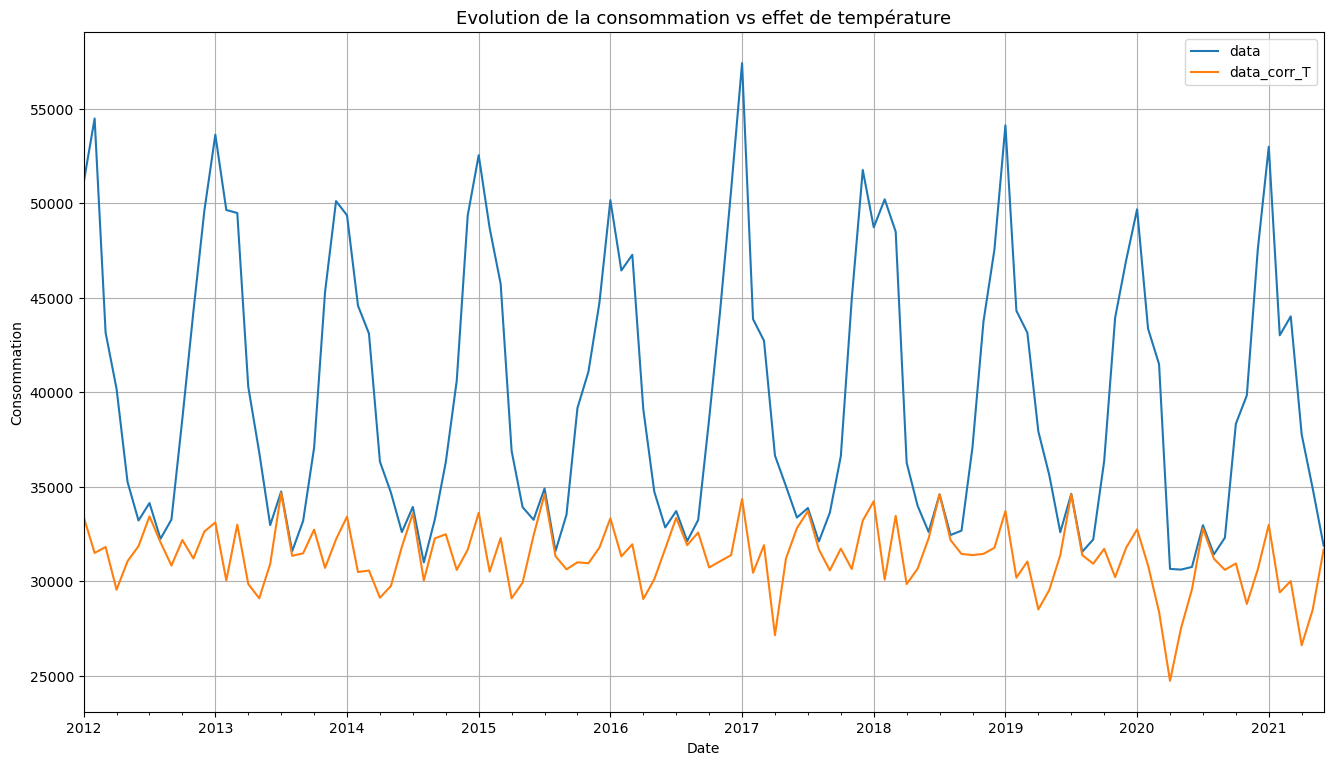

In [15]:
# on corrige la consommation de l'effet de température (à l'aide du coef 'pondération')
Sample_final["Consommation totale corrigée"] = Sample_final["Consommation totale"] - c * Sample_final["DJU_effet_T"]

# on affiche les 2 évolutions
plt.rcParams.update({'figure.figsize':(16,9), 'figure.dpi':100})
g = Sample_final.groupby(['Date']).agg({'Consommation totale':'sum','Consommation totale corrigée':'sum'})
g.rename(columns={'Consommation totale':'data','Consommation totale corrigée':'data_corr_T'}, inplace=True)
g.plot()
plt.grid(True)
plt.ylabel('Consommation')
plt.title("Evolution de la consommation vs effet de température",fontsize=13)
plt.savefig('OUTPUTS_FORMATION/P9_2_data_vs_data_corr_T.jpg',dpi=300)
plt.show()

# MISSION 2 (Désaisonnalisation de la consommation)

### Décomposition

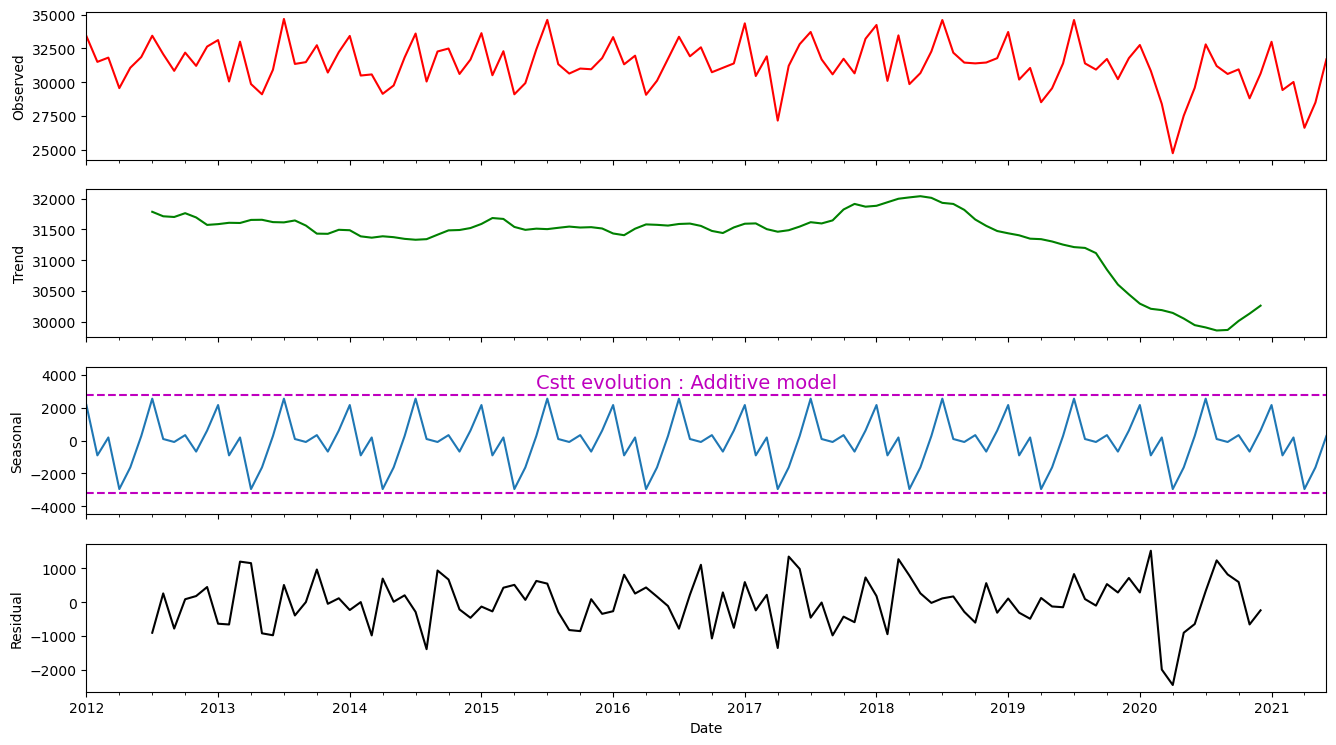

In [16]:
import statsmodels.api as sm

X = g['data_corr_T']
model = sm.tsa.seasonal_decompose(X, 
                                    model='additive', #'multiplicative'
                                        filt=None, 
                                            period=12, 
                                                two_sided=True, 
                                                    extrapolate_trend=0, 
                                                      #extrapolate_trend='freq',
                                   )
# resplot = res.plot(observed=True, seasonal=True, trend=True, resid=True, weights=False)

# autre méthode d'affichage de la décomposition
fig, axes = plt.subplots(4, 1, sharex=True, figsize=(16, 9))
model.observed.plot(ax=axes[0], legend=False, color='r')
axes[0].set_ylabel('Observed')
model.trend.plot(ax=axes[1], legend=False, color='g')
axes[1].set_ylabel('Trend')
model.seasonal.plot(ax=axes[2], legend=False)
axes[2].set_ylabel('Seasonal')
axes[2].set_ylim(-4500,4500)
axes[2].axhline(2800, c='m',ls='--')
axes[2].axhline(-3200, c='m',ls='--')
axes[2].text("2015-06-01", 3200, "Cstt evolution : Additive model",c='m',fontsize=14)
model.resid.plot(ax=axes[3], legend=False, color='k')
axes[3].set_ylabel('Residual')
plt.savefig('OUTPUTS_FORMATION/P9_3_décomposition.jpg',dpi=300)
plt.show()

In [17]:
# création d'un df regroupant les infos importantes de la décomposition
decompose = pd.DataFrame({
                            'data_corr_T': Sample_final["Consommation totale corrigée"].values,
                            'trend': model.trend.values,
                            'seasonal': model.seasonal.values, #np.exp(model.seasonal.values),
                            'resid': model.resid.values,
                        })

### Visualisation graphique des données

xmin = 15168.05, xmax = 18950.95
ymin = 24242.7155, ymax = 35178.1345 


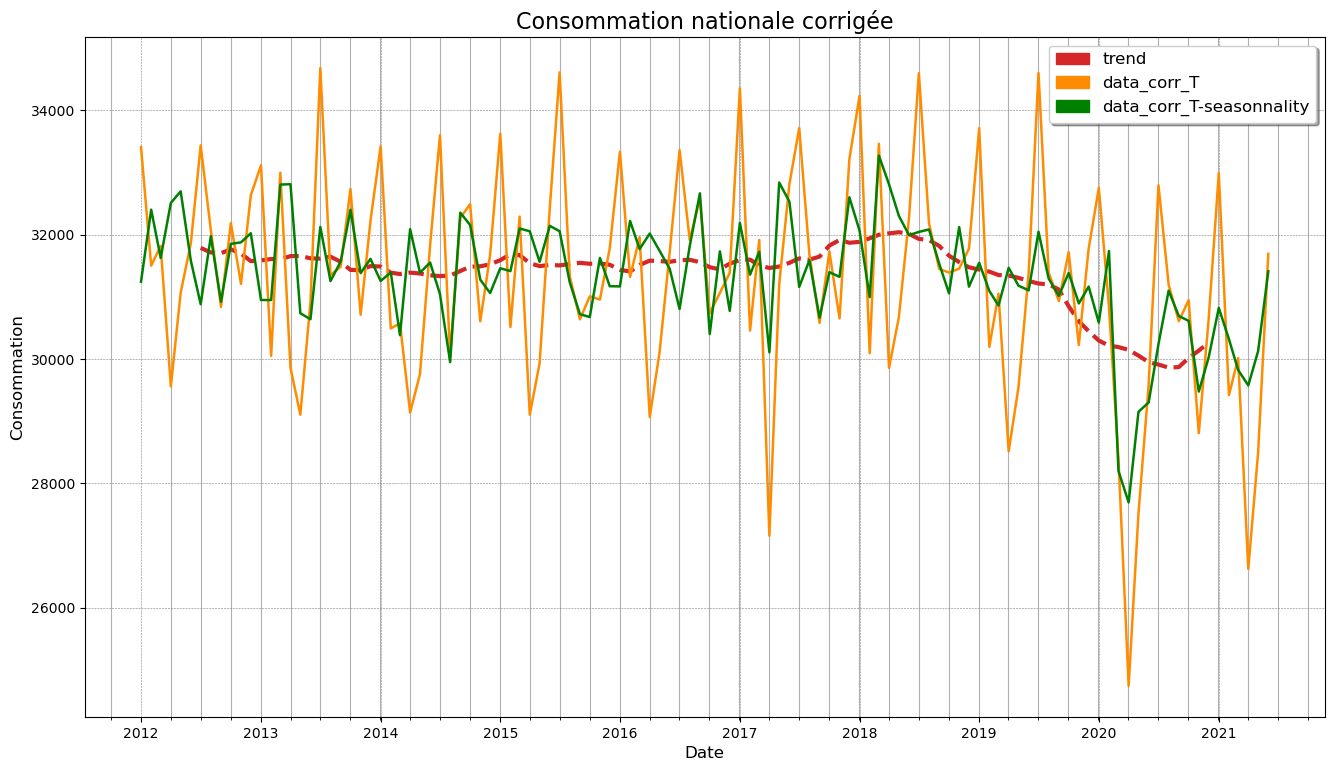

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(16, 9), dpi=100)
# on corrige la consommation corrigée de l'effet saisonnier grâce à la décomposition
decompose["data_corr_T-seasonnality"] = decompose["data_corr_T"].values - decompose["seasonal"].values
indexes = decompose.set_index(pd.to_datetime(g.index))
ax.plot(indexes.index, decompose['trend']                   ,lw=3  ,c='tab:red', ls='--')
ax.plot(indexes.index, decompose['data_corr_T']             ,lw=1.8,c='darkorange')
ax.plot(indexes.index, decompose['data_corr_T-seasonnality'],lw=1.8,c='green')
ax.set_title('Consommation nationale corrigée',fontsize=16)

my_colors = {decompose.columns[1]:'tab:red',decompose.columns[0]:'darkorange',decompose.columns[4]:'green'}          
lab_col = list(my_colors.keys())
handles = [plt.Rectangle((0,0),0,0, color=my_colors[label]) for label in lab_col]              
ax.legend(handles, lab_col, ncol=1, shadow=True, loc='best',fontsize=12)
ax.set_xlabel("Date",fontsize=12)
ax.set_ylabel("Consommation",fontsize=12)
ax.grid(color='gray', linestyle='--', linewidth=0.4)

from matplotlib.ticker import AutoMinorLocator
minor_locator = AutoMinorLocator(4)
ax.xaxis.set_minor_locator(minor_locator)
plt.grid(which='minor')
xmin, xmax, ymin, ymax = plt.axis()
s = 'xmin = ' + str(round(xmin, 2)) + ', ' + \
    'xmax = ' + str(xmax) + '\n' + \
    'ymin = ' + str(ymin) + ', ' + \
    'ymax = ' + str(ymax) + ' '
print(s)
plt.savefig('OUTPUTS_FORMATION/P9_4_desaisonnalisation.jpg',dpi=300)
plt.show()

### Comparaison trend vs. moyenne mobile

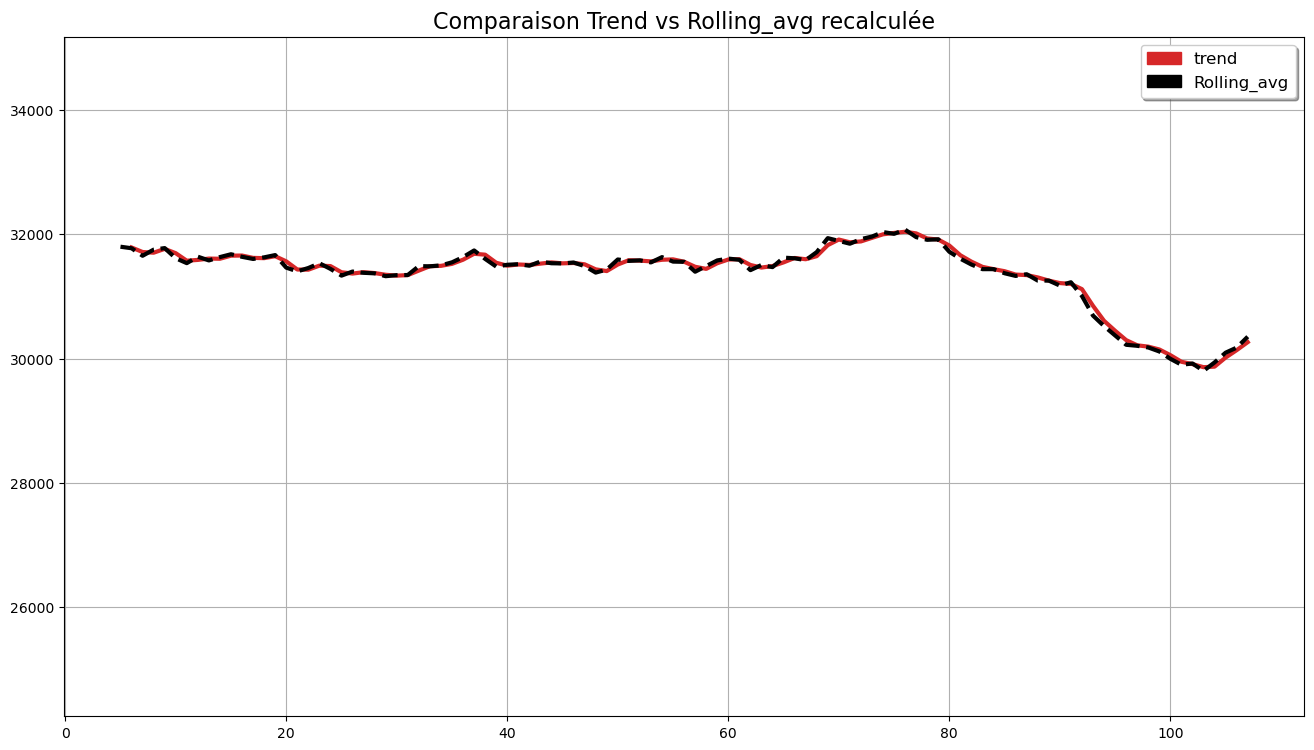

In [19]:
Rolling_avg = decompose["data_corr_T"].rolling(12).mean()
df_Rolling = pd.DataFrame({
                            'Rolling_avg': Rolling_avg,
                         })
plt.plot(decompose.index  , decompose["trend"]       , color ='tab:red',ls='-' ,lw=3)
plt.plot(decompose.index-6, df_Rolling["Rolling_avg"] , color ='k' , ls='--',lw=3)

my_colors = {decompose.columns[1]:'tab:red',df_Rolling.columns[0]:'k'}          
lab_col = list(my_colors.keys())
handles = [plt.Rectangle((0,0),0,0, color=my_colors[label]) for label in lab_col]              
plt.legend(handles, lab_col, ncol=1, shadow=True, loc='best',fontsize=12)
plt.title('Comparaison Trend vs Rolling_avg recalculée',fontsize=16)
plt.grid()
plt.ylim(ymin, ymax)
plt.savefig('OUTPUTS_FORMATION/P9_5_moving_avg_vs_trend.jpg',dpi=300)
plt.show()

# MISSION 3 (Prévision de la consommation)

## Méthodes Simpe, Holt et Holt-Winters

Problème arguments non reconnus lors de l'utilisation méthodes de lissage exponentiel Double "ExponentialSmoothing"

Suite à l'édition de la version de statsmodels avec la cmd : pip show statsmodels -> Version: 0.11.1

Problème résolu avec Update -> Version: 0.12.1 (arguments pris en compte)

### Visualisation des 3 méthodes

In [20]:
# Import Méthodes de lissage
from statsmodels.tsa.holtwinters import SimpleExpSmoothing    # single exponential smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing  # double and triple exponential smoothing

# Obtention des Coefficients (α, β, γ) issus de l'algo avec "optimization=True"
model_simple = SimpleExpSmoothing(decompose['data_corr_T']).fit()
model_double = ExponentialSmoothing(decompose['data_corr_T'],trend='add').fit()
model_triple = ExponentialSmoothing(decompose['data_corr_T'],trend='add',seasonal='add',seasonal_periods=12).fit()
# model.summary()
res_df = pd.DataFrame([model_simple.params, model_double.params, model_triple.params])
res_df.drop(res_df.columns[[3,4,5,6,7,8,9]], axis=1, inplace=True)
res_df

,smoothing_level,smoothing_trend,smoothing_seasonal
0,0.167691,NaN,NaN
1,0.463084,0.139690,NaN
2,0.148838,0.000529,0.228686


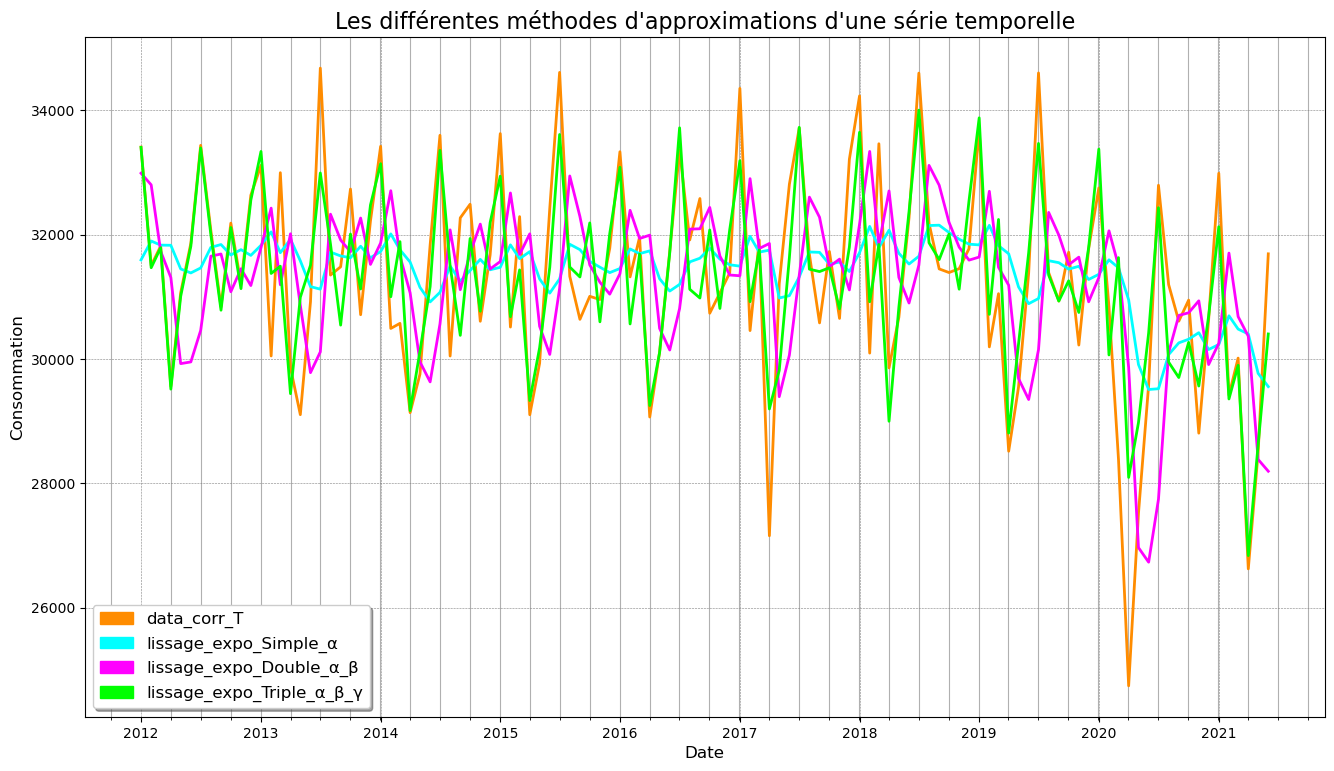

In [21]:
# Construction des différentes approximations et visualisation
''' The fit function allows you to either specify the smoothing coefficients of the exponential smoothing model 
or have them optimized. By default, they are optimized (e.g. optimized=True)
smoothing_level=alpha, smoothing_trend=beta, smoothing_seasonal=gamma, use_brute=True, optimized=True ''' 

decompose['lissage_expo_Simple_α'] = SimpleExpSmoothing(decompose['data_corr_T']).fit().fittedvalues
decompose['lissage_expo_Double_α_β'] = ExponentialSmoothing(decompose['data_corr_T'],trend='add').fit().fittedvalues
decompose['lissage_expo_Triple_α_β_γ'] = ExponentialSmoothing(decompose['data_corr_T'],trend='add',seasonal='add',seasonal_periods=12).fit().fittedvalues

fig, ax = plt.subplots(1, 1, figsize=(16, 9), dpi=100)
indexes = decompose.set_index(pd.to_datetime(g.index))
ax.plot(indexes.index, decompose['data_corr_T']                ,lw=2, c='darkorange')
ax.plot(indexes.index, decompose['lissage_expo_Simple_α']      ,lw=2, c='cyan')
ax.plot(indexes.index, decompose['lissage_expo_Double_α_β']    ,lw=2, c='magenta')
ax.plot(indexes.index, decompose['lissage_expo_Triple_α_β_γ']  ,lw=2, c='lime')

ax.set_title("Les différentes méthodes d'approximations d'une série temporelle",fontsize=16)
my_colors = {decompose.columns[0]:'darkorange',decompose.columns[5]:'cyan',
             decompose.columns[6]:'magenta',decompose.columns[7]:'lime'}          
lab_col = list(my_colors.keys())
handles = [plt.Rectangle((0,0),0,0, color=my_colors[label]) for label in lab_col]              
ax.legend(handles, lab_col, ncol=1, shadow=True, loc='lower left',fontsize=12)
ax.set_xlabel("Date",fontsize=12)
ax.set_ylabel("Consommation",fontsize=12)
ax.xaxis.set_minor_locator(minor_locator)
ax.grid(color='gray', linestyle='--', linewidth=0.4)
ax.grid(which='minor')
plt.savefig('OUTPUTS_FORMATION/P9_6_smooth_mthds.jpg',dpi=300)
plt.show()

In [22]:
# zoom pour ppt #
# decompose['lissage_expo_Simple_α'] = SimpleExpSmoothing(decompose['data_corr_T']).fit().fittedvalues
# decompose['lissage_expo_Double_α_β'] = ExponentialSmoothing(decompose['data_corr_T'],trend='add').fit().fittedvalues
# decompose['lissage_expo_Triple_α_β_γ'] = ExponentialSmoothing(decompose['data_corr_T'],trend='add',seasonal='add',seasonal_periods=12).fit().fittedvalues

# fig, ax = plt.subplots(1, 1, figsize=(16, 9), dpi=100)
# indexes = decompose.set_index(pd.to_datetime(g.index))
# ax.plot(indexes.index, decompose['data_corr_T']                ,lw=2, c='darkorange')
# ax.plot(indexes.index, decompose['lissage_expo_Simple_α']      ,lw=2, c='cyan')
# ax.plot(indexes.index, decompose['lissage_expo_Double_α_β']    ,lw=2, c='magenta')
# ax.plot(indexes.index, decompose['lissage_expo_Triple_α_β_γ']  ,lw=2, c='lime')

# ax.set_title("Les différentes méthodes d'approximations d'une série temporelle",fontsize=16)
# my_colors = {decompose.columns[0]:'darkorange',decompose.columns[5]:'cyan',
#              decompose.columns[6]:'magenta',decompose.columns[7]:'lime'}          
# lab_col = list(my_colors.keys())
# handles = [plt.Rectangle((0,0),0,0, color=my_colors[label]) for label in lab_col]              
# ax.legend(handles, lab_col, ncol=1, shadow=True, loc='lower left',fontsize=12)
# ax.set_xlabel("Date",fontsize=12)
# ax.set_ylabel("Consommation",fontsize=12)
# ax.xaxis.set_minor_locator(minor_locator)
# ax.grid(color='gray', linestyle='--', linewidth=0.4)
# ax.grid(which='minor')
# ax.set_xlim(indexes.index[70],indexes.index[90])
# ax.set_ylim(2.8e4,3.5e4)
# plt.show()

### Trade-off Méthode lissage Simple (LES)

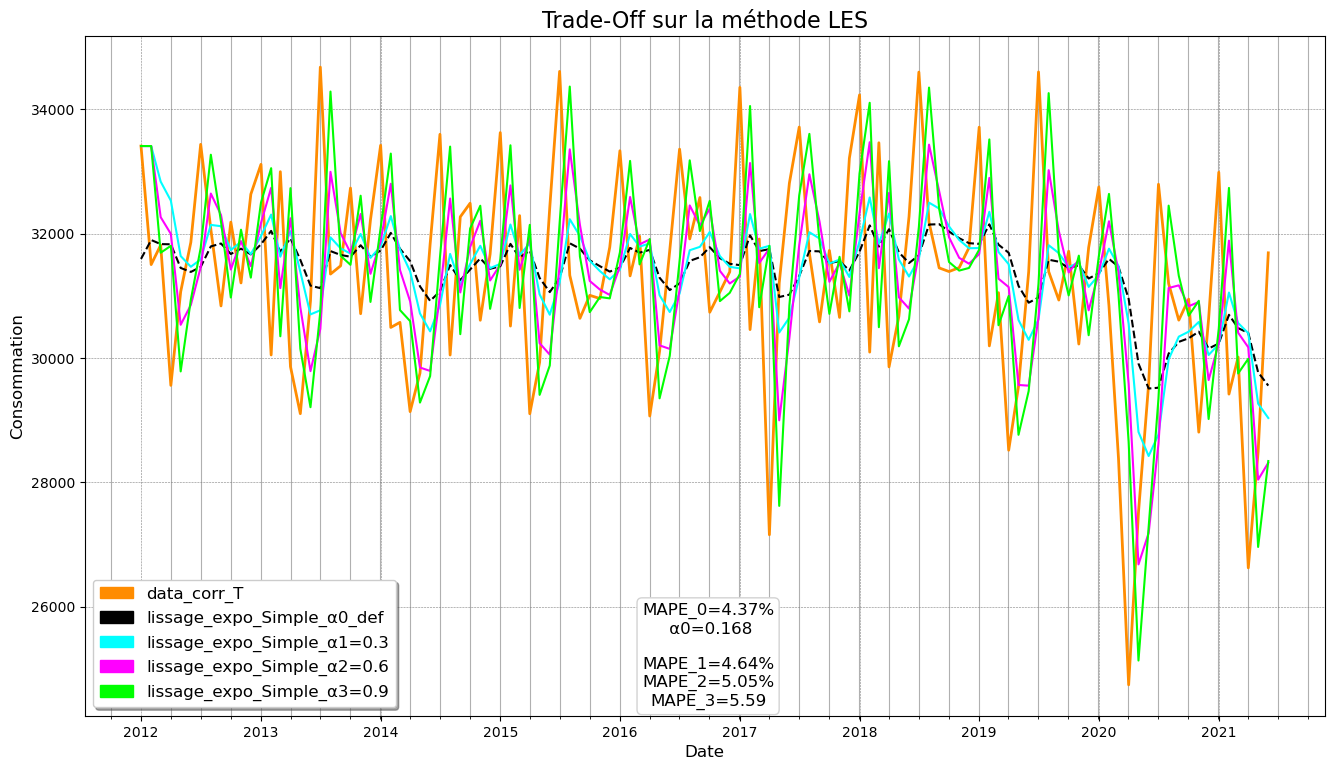

In [23]:
α0_def = SimpleExpSmoothing(decompose['data_corr_T']).fit().fittedvalues
α1 = SimpleExpSmoothing(decompose['data_corr_T']).fit(smoothing_level=0.3, use_brute=True, optimized=False).fittedvalues
α2 = SimpleExpSmoothing(decompose['data_corr_T']).fit(smoothing_level=0.6, use_brute=True, optimized=False).fittedvalues
α3 = SimpleExpSmoothing(decompose['data_corr_T']).fit(smoothing_level=0.9, use_brute=True, optimized=False).fittedvalues

decompose['lissage_expo_Simple_α0_def'] = SimpleExpSmoothing(decompose['data_corr_T']).fit().fittedvalues
decompose['lissage_expo_Simple_α1'] = SimpleExpSmoothing(decompose['data_corr_T']).fit(smoothing_level=0.3, use_brute=True, optimized=False).fittedvalues
decompose['lissage_expo_Simple_α2'] = SimpleExpSmoothing(decompose['data_corr_T']).fit(smoothing_level=0.6, use_brute=True, optimized=False).fittedvalues
decompose['lissage_expo_Simple_α3'] = SimpleExpSmoothing(decompose['data_corr_T']).fit(smoothing_level=0.9, use_brute=True, optimized=False).fittedvalues

fig, ax = plt.subplots(1, 1, figsize=(16, 9), dpi=100)
indexes = decompose.set_index(pd.to_datetime(g.index))
ax.plot(indexes.index, decompose['data_corr_T']             ,lw=2, c='darkorange')
ax.plot(indexes.index, decompose['lissage_expo_Simple_α0_def']  ,lw=1.5, c='k', ls='--')
ax.plot(indexes.index, decompose['lissage_expo_Simple_α1']  ,lw=1.5, c='cyan')
ax.plot(indexes.index, decompose['lissage_expo_Simple_α2']  ,lw=1.5, c='magenta')
ax.plot(indexes.index, decompose['lissage_expo_Simple_α3']  ,lw=1.5, c='lime')

ax.set_title("Trade-Off sur la méthode LES",fontsize=16)
my_colors = {decompose.columns[0]:'darkorange',decompose.columns[8]:'k',decompose.columns[9]+'=0.3':'cyan',
             decompose.columns[10]+'=0.6':'magenta',decompose.columns[11]+'=0.9':'lime'}          
lab_col = list(my_colors.keys())
handles = [plt.Rectangle((0,0),0,0, color=my_colors[label]) for label in lab_col]              
ax.legend(handles, lab_col, ncol=1, shadow=True, loc='lower left',fontsize=12)
ax.set_xlabel("Date",fontsize=12)
ax.set_ylabel("Consommation",fontsize=12)
ax.xaxis.set_minor_locator(minor_locator)
ax.grid(color='gray', linestyle='--', linewidth=0.4)
ax.grid(which='minor')
# Metrics
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
MAPE0 = mean_absolute_percentage_error(decompose['data_corr_T'],α0_def).round(2)
MAPE1 = mean_absolute_percentage_error(decompose['data_corr_T'],α1).round(2)
MAPE2 = mean_absolute_percentage_error(decompose['data_corr_T'],α2).round(2)
MAPE3 = mean_absolute_percentage_error(decompose['data_corr_T'],α3).round(2)
rate_0 = res_df.iloc[0,res_df.columns.get_loc('smoothing_level')]
myString = str("MAPE_0="+str(MAPE0)+"%"+"\n α0="+str(round(rate_0,3))+"\n\n"+"MAPE_1="+str(MAPE1)+"%\n"+"MAPE_2="+str(MAPE2)+"%\n"+"MAPE_3="+str(MAPE3))
ax.text(1.707e4, 2.52e4, myString , size=12, rotation=0.,ha="center", va="center",bbox=dict(facecolor='w',edgecolor='lightgray', alpha=1, boxstyle="round"))#,fc=(1., 0.8, 0.8),ec=(1., 0.5, 0.5)
plt.savefig('OUTPUTS_FORMATION/P9_7_tradeoff1_LES.jpg',dpi=300)
plt.show()

### Trade-off Méthode lissage Double (LED)

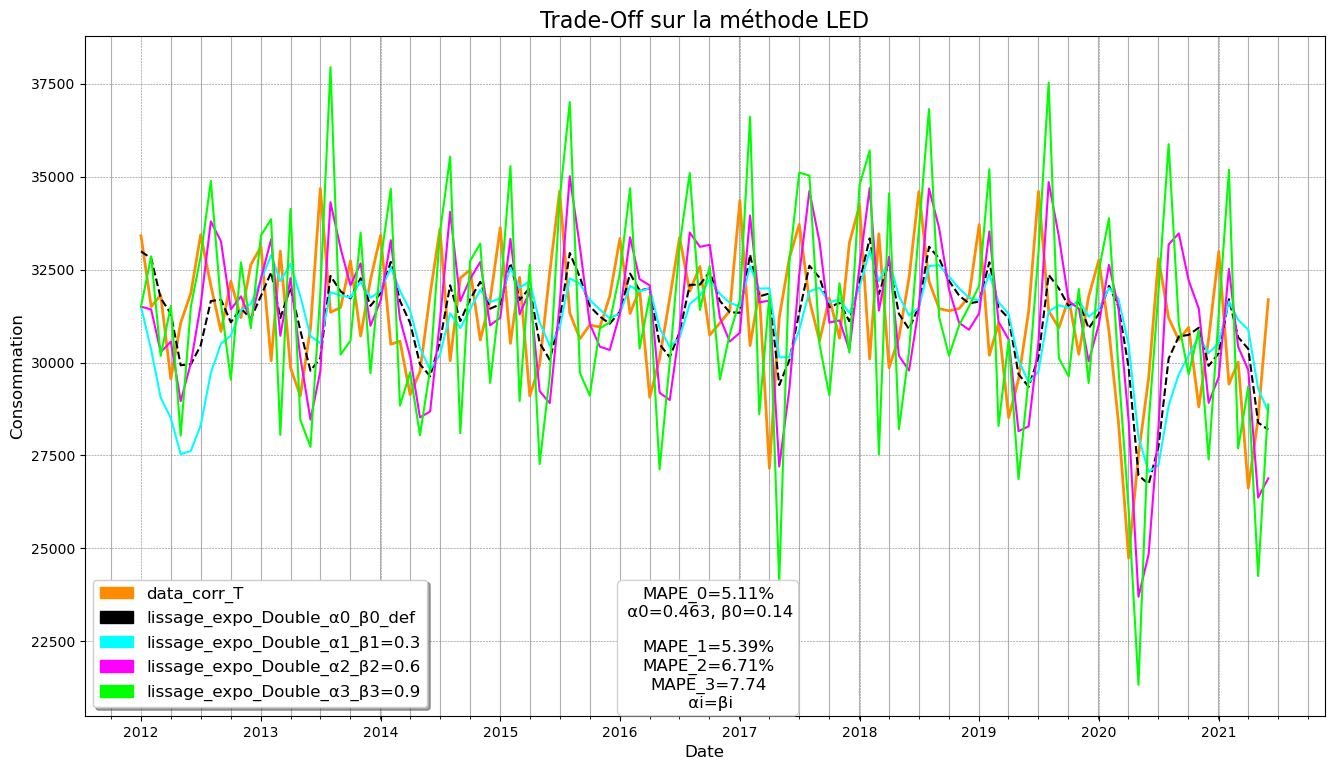

In [24]:
α0_β0_def = ExponentialSmoothing(decompose['data_corr_T'],trend='add').fit().fittedvalues
α1_β1 = ExponentialSmoothing(decompose['data_corr_T'],trend='add').fit(smoothing_level=0.3, smoothing_trend=0.3, use_brute=True, optimized=False).fittedvalues
α2_β2 = ExponentialSmoothing(decompose['data_corr_T'],trend='add').fit(smoothing_level=0.6, smoothing_trend=0.6, use_brute=True, optimized=False).fittedvalues
α3_β3 = ExponentialSmoothing(decompose['data_corr_T'],trend='add').fit(smoothing_level=0.9, smoothing_trend=0.9, use_brute=True, optimized=False).fittedvalues

decompose['lissage_expo_Double_α0_β0_def'] = ExponentialSmoothing(decompose['data_corr_T'],trend='add').fit().fittedvalues
decompose['lissage_expo_Double_α1_β1'] = ExponentialSmoothing(decompose['data_corr_T'],trend='add').fit(smoothing_level=0.3, smoothing_trend=0.3, use_brute=True, optimized=False).fittedvalues
decompose['lissage_expo_Double_α2_β2'] = ExponentialSmoothing(decompose['data_corr_T'],trend='add').fit(smoothing_level=0.6, smoothing_trend=0.6, use_brute=True, optimized=False).fittedvalues
decompose['lissage_expo_Double_α3_β3'] = ExponentialSmoothing(decompose['data_corr_T'],trend='add').fit(smoothing_level=0.9, smoothing_trend=0.9, use_brute=True, optimized=False).fittedvalues

fig, ax = plt.subplots(1, 1, figsize=(16, 9), dpi=100)
indexes = decompose.set_index(pd.to_datetime(g.index))
ax.plot(indexes.index, decompose['data_corr_T']             ,lw=2, c='darkorange')
ax.plot(indexes.index, decompose['lissage_expo_Double_α0_β0_def']  ,lw=1.5, c='k', ls='--')
ax.plot(indexes.index, decompose['lissage_expo_Double_α1_β1']  ,lw=1.5, c='cyan')
ax.plot(indexes.index, decompose['lissage_expo_Double_α2_β2']  ,lw=1.5, c='magenta')
ax.plot(indexes.index, decompose['lissage_expo_Double_α3_β3']  ,lw=1.5, c='lime')

ax.set_title("Trade-Off sur la méthode LED",fontsize=16)
my_colors = {decompose.columns[0]:'darkorange',decompose.columns[12]:'k',decompose.columns[13]+'=0.3':'cyan',
             decompose.columns[14]+'=0.6':'magenta',decompose.columns[15]+'=0.9':'lime'}          
lab_col = list(my_colors.keys())
handles = [plt.Rectangle((0,0),0,0, color=my_colors[label]) for label in lab_col]              
ax.legend(handles, lab_col, ncol=1, shadow=True, loc='lower left',fontsize=12)
ax.set_xlabel("Date",fontsize=12)
ax.set_ylabel("Consommation",fontsize=12)
ax.xaxis.set_minor_locator(minor_locator)
ax.grid(color='gray', linestyle='--', linewidth=0.4)
ax.grid(which='minor')
MAPE0 = mean_absolute_percentage_error(decompose['data_corr_T'],α0_β0_def).round(2)
MAPE1 = mean_absolute_percentage_error(decompose['data_corr_T'],α1_β1).round(2)
MAPE2 = mean_absolute_percentage_error(decompose['data_corr_T'],α2_β2).round(2)
MAPE3 = mean_absolute_percentage_error(decompose['data_corr_T'],α3_β3).round(2)
rate_0 = res_df.iloc[1,res_df.columns.get_loc('smoothing_level')]
rate_1 = res_df.iloc[1,res_df.columns.get_loc('smoothing_trend')]
myString = str("MAPE_0="+str(MAPE0)+"%"+"\n α0="+str(round(rate_0,3))+", β0="+str(round(rate_1,3))+"\n\n"+"MAPE_1="+str(MAPE1)+"%\n"+"MAPE_2="+str(MAPE2)+"%\n"+"MAPE_3="+str(MAPE3)+"\n αi=βi")
ax.text(1.707e4, 2.23e4, myString , size=12, rotation=0.,ha="center", va="center",bbox=dict(facecolor='w',edgecolor='lightgray', alpha=1, boxstyle="round"))#,fc=(1., 0.8, 0.8),ec=(1., 0.5, 0.5)
plt.savefig('OUTPUTS_FORMATION/P9_7_tradeoff2_LED.jpg',dpi=300)
plt.show()

### Trade-off Méthode lissage Holt-Winters (HW)

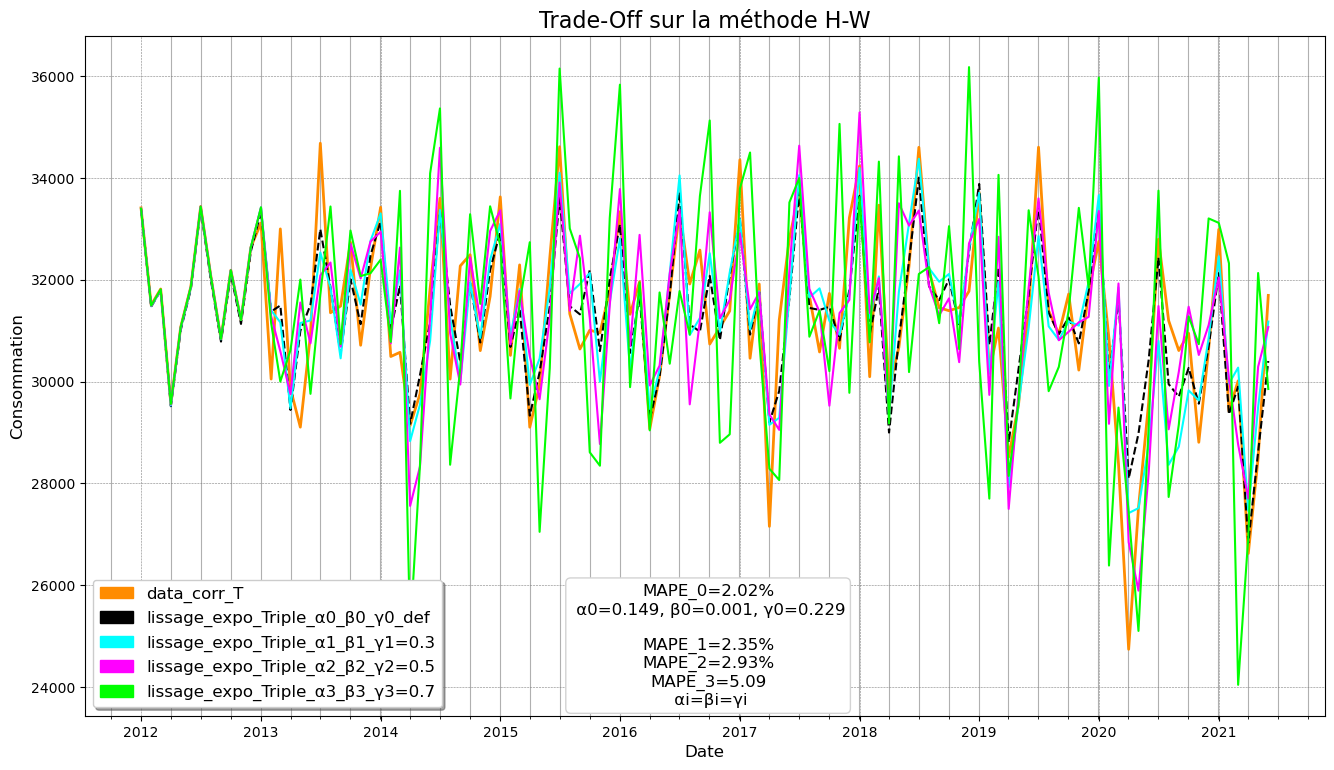

In [25]:
α0_β0_γ0_def = ExponentialSmoothing(decompose['data_corr_T'],trend='add',seasonal='add',seasonal_periods=12).fit().fittedvalues
α1_β1_γ1 = ExponentialSmoothing(decompose['data_corr_T'],trend='add',seasonal='add',seasonal_periods=12).fit(smoothing_level=0.3, smoothing_trend=0.3, smoothing_seasonal=0.3, use_brute=True, optimized=False).fittedvalues
α2_β2_γ2 = ExponentialSmoothing(decompose['data_corr_T'],trend='add',seasonal='add',seasonal_periods=12).fit(smoothing_level=0.5, smoothing_trend=0.5, smoothing_seasonal=0.5, use_brute=True, optimized=False).fittedvalues
α3_β3_γ3 = ExponentialSmoothing(decompose['data_corr_T'],trend='add',seasonal='add',seasonal_periods=12).fit(smoothing_level=0.7, smoothing_trend=0.7, smoothing_seasonal=0.7, use_brute=True, optimized=False).fittedvalues

decompose['lissage_expo_Triple_α0_β0_γ0_def'] = ExponentialSmoothing(decompose['data_corr_T'],trend='add',seasonal='add',seasonal_periods=12).fit().fittedvalues
decompose['lissage_expo_Triple_α1_β1_γ1'] = ExponentialSmoothing(decompose['data_corr_T'],trend='add',seasonal='add',seasonal_periods=12).fit(smoothing_level=0.3, smoothing_trend=0.3, smoothing_seasonal=0.3, use_brute=True, optimized=False).fittedvalues
decompose['lissage_expo_Triple_α2_β2_γ2'] = ExponentialSmoothing(decompose['data_corr_T'],trend='add',seasonal='add',seasonal_periods=12).fit(smoothing_level=0.5, smoothing_trend=0.5, smoothing_seasonal=0.5, use_brute=True, optimized=False).fittedvalues
decompose['lissage_expo_Triple_α3_β3_γ3'] = ExponentialSmoothing(decompose['data_corr_T'],trend='add',seasonal='add',seasonal_periods=12).fit(smoothing_level=0.7, smoothing_trend=0.7, smoothing_seasonal=0.7, use_brute=True, optimized=False).fittedvalues

fig, ax = plt.subplots(1, 1, figsize=(16, 9), dpi=100)
indexes = decompose.set_index(pd.to_datetime(g.index))
ax.plot(indexes.index, decompose['data_corr_T']             ,lw=2, c='darkorange')
ax.plot(indexes.index, decompose['lissage_expo_Triple_α0_β0_γ0_def']  ,lw=1.5, c='k', ls='--')
ax.plot(indexes.index, decompose['lissage_expo_Triple_α1_β1_γ1']  ,lw=1.5, c='cyan')
ax.plot(indexes.index, decompose['lissage_expo_Triple_α2_β2_γ2']  ,lw=1.5, c='magenta')
ax.plot(indexes.index, decompose['lissage_expo_Triple_α3_β3_γ3']  ,lw=1.5, c='lime')

ax.set_title("Trade-Off sur la méthode H-W",fontsize=16)
my_colors = {decompose.columns[0]:'darkorange',decompose.columns[16]:'k',decompose.columns[17]+'=0.3':'cyan',
             decompose.columns[18]+'=0.5':'magenta',decompose.columns[19]+'=0.7':'lime'}          
lab_col = list(my_colors.keys())
handles = [plt.Rectangle((0,0),0,0, color=my_colors[label]) for label in lab_col]              
ax.legend(handles, lab_col, ncol=1, shadow=True, loc='lower left',fontsize=12)
ax.set_xlabel("Date",fontsize=12)
ax.set_ylabel("Consommation",fontsize=12)
ax.xaxis.set_minor_locator(minor_locator)
ax.grid(color='gray', linestyle='--', linewidth=0.4)
ax.grid(which='minor')
MAPE0 = mean_absolute_percentage_error(decompose['data_corr_T'],α0_β0_γ0_def).round(2)
MAPE1 = mean_absolute_percentage_error(decompose['data_corr_T'],α1_β1_γ1).round(2)
MAPE2 = mean_absolute_percentage_error(decompose['data_corr_T'],α2_β2_γ2).round(2)
MAPE3 = mean_absolute_percentage_error(decompose['data_corr_T'],α3_β3_γ3).round(2)
rate_0 = res_df.iloc[2,res_df.columns.get_loc('smoothing_level')]
rate_1 = res_df.iloc[2,res_df.columns.get_loc('smoothing_trend')]
rate_2 = res_df.iloc[2,res_df.columns.get_loc('smoothing_seasonal')]
myString = str("MAPE_0="+str(MAPE0)+"%"+"\n α0="+str(round(rate_0,3))+", β0="+str(round(rate_1,3))+", γ0="+str(round(rate_2,3))+"\n\n"+"MAPE_1="+str(MAPE1)+"%\n"+"MAPE_2="+str(MAPE2)+"%\n"+"MAPE_3="+str(MAPE3)+"\n αi=βi=γi")
ax.text(1.707e4, 2.48e4, myString , size=12, rotation=0.,ha="center", va="center",bbox=dict(facecolor='w',edgecolor='lightgray', alpha=1, boxstyle="round"))#,fc=(1., 0.8, 0.8),ec=(1., 0.5, 0.5)
plt.savefig('OUTPUTS_FORMATION/P9_7_tradeoff3_HW.jpg',dpi=300)
plt.show()

### Fit (HW)

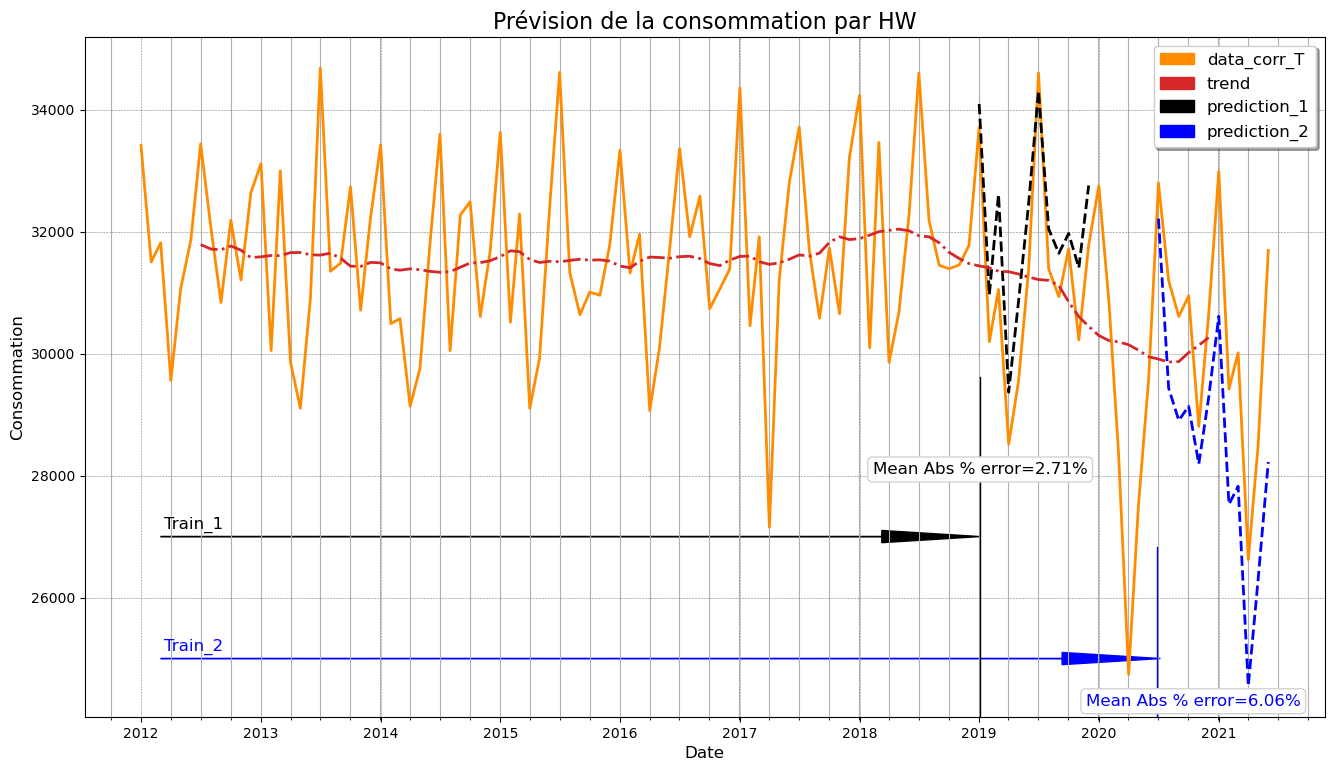

In [26]:
# on retire les données post 01/01/2019 et teste sur 12 mois
train_decompose_1 = decompose[:84] 
test_decompose_1 = decompose[84:96]

train_decompose_2 = decompose[:102] 
test_decompose_2 = decompose[102:] 

model_triple_pred_1 = ExponentialSmoothing(train_decompose_1['data_corr_T'],trend='add',seasonal='add',seasonal_periods=12).fit()
prediction_1 = model_triple_pred_1.forecast(len(test_decompose_1))
model_triple_pred_2 = ExponentialSmoothing(train_decompose_2['data_corr_T'],trend='add',seasonal='add',seasonal_periods=12).fit()
prediction_2 = model_triple_pred_2.forecast(len(test_decompose_2))

fig, ax = plt.subplots(1, 1, figsize=(16, 9), dpi=100)
indexes = decompose.set_index(pd.to_datetime(g.index))
ax.plot(indexes.index, decompose['data_corr_T']               ,lw=2, c='darkorange',   ls='-')
# ax.plot(indexes.index[:96], train_decompose_1['data_corr_T'] ,lw=2, c='darkorange',   ls='-')
# ax.plot(indexes.index[72:84], test_decompose_1['data_corr_T']  ,lw=2, c='green',   ls='-')
ax.plot(indexes.index[84:96], prediction_1                     ,lw=2, c='k',   ls='--')
# ax.plot(indexes.index[:102], train_decompose_2['data_corr_T'] ,lw=2, c='navajowhite',   ls='-')
# ax.plot(indexes.index[102:], test_decompose_2['data_corr_T']  ,lw=2, c='lime',   ls='-')
ax.plot(indexes.index[102:], prediction_2                     ,lw=2, c='b',   ls='--')
ax.plot(indexes.index, decompose["trend"]                    ,lw=2, c='tab:red', ls='-.')

ax.set_title("Prévision de la consommation par HW",fontsize=16)
my_colors = {"data_corr_T":'darkorange',"trend":'tab:red', "prediction_1":'k', "prediction_2":'b' }          
lab_col = list(my_colors.keys())
handles = [plt.Rectangle((0,0),0,0, color=my_colors[label]) for label in lab_col]              
ax.legend(handles, lab_col, ncol=1, shadow=True, loc='best',fontsize=12)
ax.set_xlabel("Date",fontsize=12)
ax.set_ylabel("Consommation",fontsize=12)
ax.xaxis.set_minor_locator(minor_locator)
ax.grid(color='gray', linestyle='--', linewidth=0.4)
ax.grid(which='minor')
MAPE_pred_1 = mean_absolute_percentage_error(test_decompose_1['data_corr_T'],prediction_1).round(2)
MAPE_pred_2 = mean_absolute_percentage_error(test_decompose_2['data_corr_T'],prediction_2).round(2)
myString_1 = str("Mean Abs % error="+str(MAPE_pred_1)+"%")
myString_2 = str("Mean Abs % error="+str(MAPE_pred_2)+"%")
ax.text(1.79e4, 2.81e4, myString_1 ,color='k', size=12, rotation=0.,ha="center", va="center",bbox=dict(facecolor='w',edgecolor='lightgray', alpha=1, boxstyle="round"))#,fc=(1., 0.8, 0.8),ec=(1., 0.5, 0.5)
ax.text(1.855e4, 2.43e4, myString_2 ,color='b', size=12, rotation=0.,ha="center", va="center",bbox=dict(facecolor='w',edgecolor='lightgray', alpha=1, boxstyle="round"))#,fc=(1., 0.8, 0.8),ec=(1., 0.5, 0.5)
ax.text(1.55e4, 2.72e4, 'Train_1' ,color='k', size=12, rotation=0.,ha="center", va="center")
ax.text(1.55e4, 2.52e4, 'Train_2' ,color='b', size=12, rotation=0.,ha="center", va="center")
ax.arrow(1.54e4, 2.7e4, 2200, 0, head_width=200, width=0.01, ec ='k', fc ='k')
ax.arrow(1.54e4, 2.5e4, 2750, 0, head_width=200, width=0.01, ec ='b', fc ='b')
ax.axvline(x=1.79e4, c='k', ymin=0, ymax=.5,lw=1)
ax.axvline(x=1.844e4, c='b', ymin=0, ymax=.25,lw=1)
plt.savefig('OUTPUTS_FORMATION/P9_8_predicion_HW.jpg',dpi=300)
plt.show()

### Analyse des résidus

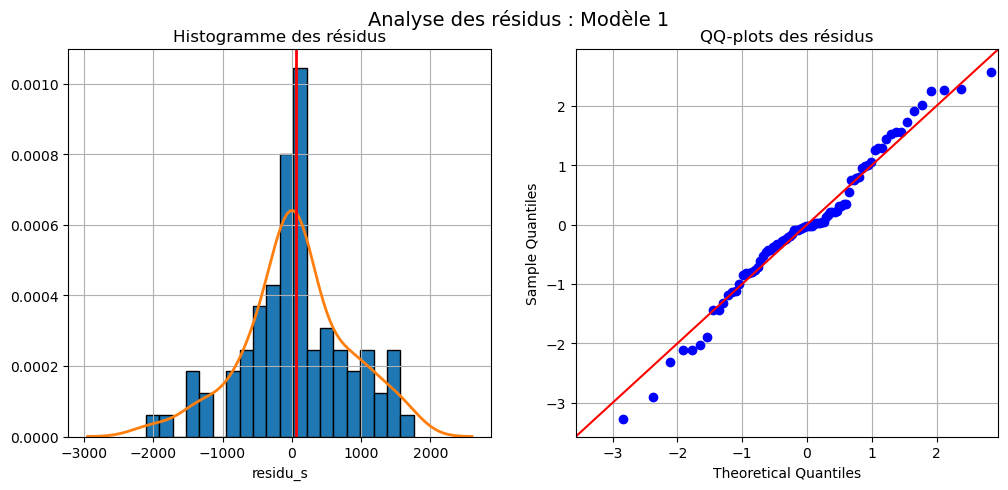

ShapiroResult(statistic=0.9757609963417053, pvalue=0.11378653347492218)
 Par le test de Shapiro-Wilk, avec une p_value >> 5% on peut retenir l’hypothèse de normalité (Ho) 
 La forme de la distribution est à 98% similaire à une loi normale, et est homogène selon la pvalue 


In [27]:
fig = plt.figure(figsize=(12, 5))
plt.suptitle("Analyse des résidus : Modèle 1", fontsize=14)
plt.tight_layout()
plt.subplots_adjust(top=0.9)

ax = fig.add_subplot(1, 2, 1)
train_decompose_1['residu_s'] = model_triple_pred_1.resid
plt.xlabel('Résidus')
plt.title('Histogramme des résidus')
sns.distplot(train_decompose_1['residu_s'], bins=20,kde_kws={"color": "tab:orange", "lw": 2},
             hist_kws={"histtype": "bar", "lw": 1,"alpha": 1, "color": "tab:blue","edgecolor":"black"}, ax=ax)
plt.axvline(np.mean(train_decompose_1['residu_s']), color='r', linewidth=2)
plt.grid()

ax = fig.add_subplot(1, 2, 2)
sm.qqplot(model_triple_pred_1.resid, stats.t, fit=True, line="45", ax=ax)
plt.grid()
plt.title("QQ-plots des résidus",fontsize=12)
plt.savefig('OUTPUTS_FORMATION/P9_9_residus_mdl1.jpg',dpi=300)
plt.show()
print(st.shapiro(model_triple_pred_1.resid))
print('\x1b[6;32;40m',"Par le test de Shapiro-Wilk, avec une p_value >> 5% on peut retenir l’hypothèse de normalité (Ho)",'\x1b[0m')
print('\x1b[6;32;40m',"La forme de la distribution est à 98% similaire à une loi normale, et est homogène selon la pvalue",'\x1b[0m')

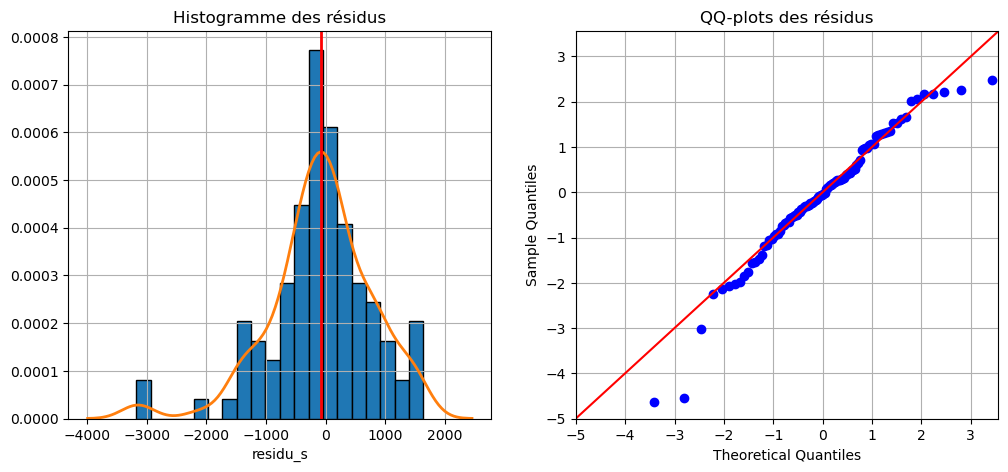

ShapiroResult(statistic=0.9555711150169373, pvalue=0.0017328578978776932)
 Par le test de Shapiro-Wilk, avec une p_value << 5% on ne peut pas retenir l’hypothèse de normalité (Ho) 
 La forme de la distribution est à 96% similaire à une loi normale, mais n'est pas homogène selon la pvalue 


In [28]:
fig = plt.figure(figsize=(12, 5))
# plt.suptitle("Analyse des résidus : Modèle 2", fontsize=14)
plt.tight_layout()
plt.subplots_adjust(top=0.9)

ax = fig.add_subplot(1, 2, 1)
train_decompose_2['residu_s'] = model_triple_pred_2.resid
plt.xlabel('Résidus')
plt.title('Histogramme des résidus')
sns.distplot(train_decompose_2['residu_s'], bins=20,kde_kws={"color": "tab:orange", "lw": 2},
             hist_kws={"histtype": "bar", "lw": 1,"alpha": 1, "color": "tab:blue","edgecolor":"black"}, ax=ax)
plt.axvline(np.mean(train_decompose_2['residu_s']), color='r', linewidth=2)
plt.grid()

ax = fig.add_subplot(1, 2, 2)
sm.qqplot(model_triple_pred_2.resid, stats.t, fit=True, line="45", ax=ax)
plt.grid()
plt.title("QQ-plots des résidus",fontsize=12)
plt.savefig('OUTPUTS_FORMATION/P9_9_residus_mdl2.jpg',dpi=300)
plt.show()
print(st.shapiro(model_triple_pred_2.resid))
print('\x1b[6;31;40m',"Par le test de Shapiro-Wilk, avec une p_value << 5% on ne peut pas retenir l’hypothèse de normalité (Ho)",'\x1b[0m')
print('\x1b[6;31;40m',"La forme de la distribution est à 96% similaire à une loi normale, mais n'est pas homogène selon la pvalue",'\x1b[0m')

In [29]:
print(sm.stats.acorr_ljungbox(model_triple_pred_2.resid, lags=[1,2,3,4,5,6,7,8,9,10,11,12], return_df=True))
print('\x1b[6;31;40m',"On ne rejète pas l’hypothèse H0 d’un bruit blanc avec une pvalue > 5%.",'\x1b[0m')
# reject of H0 => residuals are dependent.

     lb_stat  lb_pvalue
1   0.748692   0.386891
2   1.128541   0.568775
3   1.290406   0.731412
4   2.053428   0.725933
5   2.053439   0.841702
6   2.243252   0.896023
7   2.520884   0.925516
8   5.436457   0.710069
9   5.600604   0.779130
10  5.904840   0.823194
11  5.976590   0.874922
12  6.764818   0.872756
 On ne rejète pas l’hypothèse H0 d’un bruit blanc avec une pvalue > 5%. 


## Méthode SARIMA

### Vérification initiale de la stationnarité de la consommation corrigée

Si p-value du test de Dickey-Fuller < 5%, on rejette H0 (série générée par un processus présentant une racine unitaire, et donc, qu'elle n'est pas stationnaire)

In [30]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
data = decompose['data_corr_T']

#ADF-test(Original-time-series)
result = adfuller(data.dropna())
print('ADF Statistic Original-time-series: %f' % result[0])
print('p-value: %f' % result[1],'\x1b[6;31;40m',"si > 5% => instationnarité => différenciation nécessaire",'\x1b[0m \n')

#ADF-test(differenced-time-series)
result = adfuller(data.diff().dropna())
print('ADF Statistic differenced-time-series: %f' % result[0])
print('p-value: %f' % result[1],'\x1b[6;32;40m',"   < 5% => stationnarité établie => d = 1",'\x1b[0m')

ADF Statistic Original-time-series: -0.597431
p-value: 0.871561  si > 5% => instationnarité => différenciation nécessaire  

ADF Statistic differenced-time-series: -6.198265
p-value: 0.000000     < 5% => stationnarité établie => d = 1 


### Analyse des séries différenciées pour plusieurs ordres

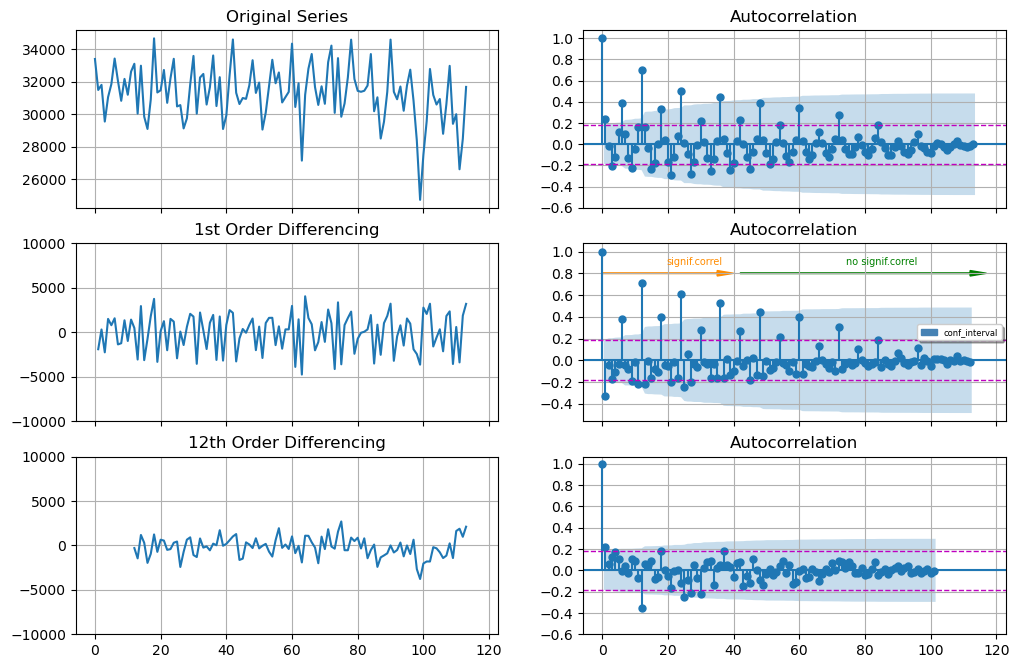

In [31]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, axes = plt.subplots(3, 2, sharex=True,figsize=(12,8))
# Original Series
axes[0, 0].plot(data); axes[0, 0].set_title('Original Series')
plot_acf(data, ax=axes[0, 1], lags=len(data)-1,use_vlines=True,missing='drop')
axes[0, 0].grid()
axes[0, 1].grid(); axes[0,1].set_yticks(np.arange(-0.6,1.1,0.2))
axes[0, 1].axhline(y=-1.96/np.sqrt(len(data)),linestyle='--',color='m',lw=1)
axes[0, 1].axhline(y=1.96/np.sqrt(len(data)),linestyle='--',color='m',lw=1)

# 1st Differencing
axes[1, 0].plot(data.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(data.diff(), ax=axes[1, 1], lags=len(data.diff().dropna())-1,use_vlines=True,missing='drop')
axes[1, 0].grid();axes[1, 0].set_yticks(np.arange(-1e4,1.5e4,5e3))
axes[1, 1].grid();axes[1, 1].set_yticks(np.arange(-0.6,1.1,0.2))
my_colors = {'conf_interval':'steelblue'}          
lab_col = list(my_colors.keys())
handles = [plt.Rectangle((0,0),0,0, color=my_colors[label]) for label in lab_col]              
axes[1, 1].legend(handles, lab_col, ncol=1, shadow=True, loc='center right',fontsize=6)
axes[1, 1].arrow(0,0.8,35,0, head_width=0.05, head_length=5, width=0.005, ec ='darkorange', fc ='darkorange')
axes[1, 1].arrow(42,0.8,70,0, head_width=0.05, head_length=5, width=0.005, ec ='g', fc ='g')
axes[1, 1].text(28, .9, "signif.correl" ,color='darkorange', size=7, rotation=0.,ha="center", va="center")
axes[1, 1].text(85, .9, "no signif.correl" ,color='g', size=7, rotation=0.,ha="center", va="center")
axes[1, 1].axhline(y=-1.96/np.sqrt(len(data)),linestyle='--',color='m',lw=1)
axes[1, 1].axhline(y=1.96/np.sqrt(len(data)),linestyle='--',color='m',lw=1)

# 12th Differencing
i = 12
axes[2, 0].plot(data.diff(12)); axes[2, 0].set_title('12th Order Differencing')
plot_acf(data.diff(12), ax=axes[2, 1], lags=len(data.diff(12).dropna())-1,use_vlines=True,missing='drop') #
axes[2, 0].grid();axes[2, 0].set_yticks(np.arange(-1e4,1.5e4,5e3))
axes[2, 1].grid();axes[2, 1].set_yticks(np.arange(-0.6,1.1,0.2))
# axes[2, 1].set_ylim(-.4,.4)
axes[2, 1].axhline(y=-1.96/np.sqrt(len(data)),linestyle='--',color='m',lw=1)
axes[2, 1].axhline(y=1.96/np.sqrt(len(data)),linestyle='--',color='m',lw=1)
plt.savefig('OUTPUTS_FORMATION/P9_91_diffencing_order.jpg',dpi=300)
plt.show()

Stationnarité établie pour s = 12

### Partial Autocorrelation (PACF) et ordre du AR term (p)

Fonction d'autocorrélation partielle (PACF). Au décalage k, il s'agit de la corrélation entre les valeurs de séries séparées par k intervalles, compte tenu des valeurs des intervalles intermédiaires

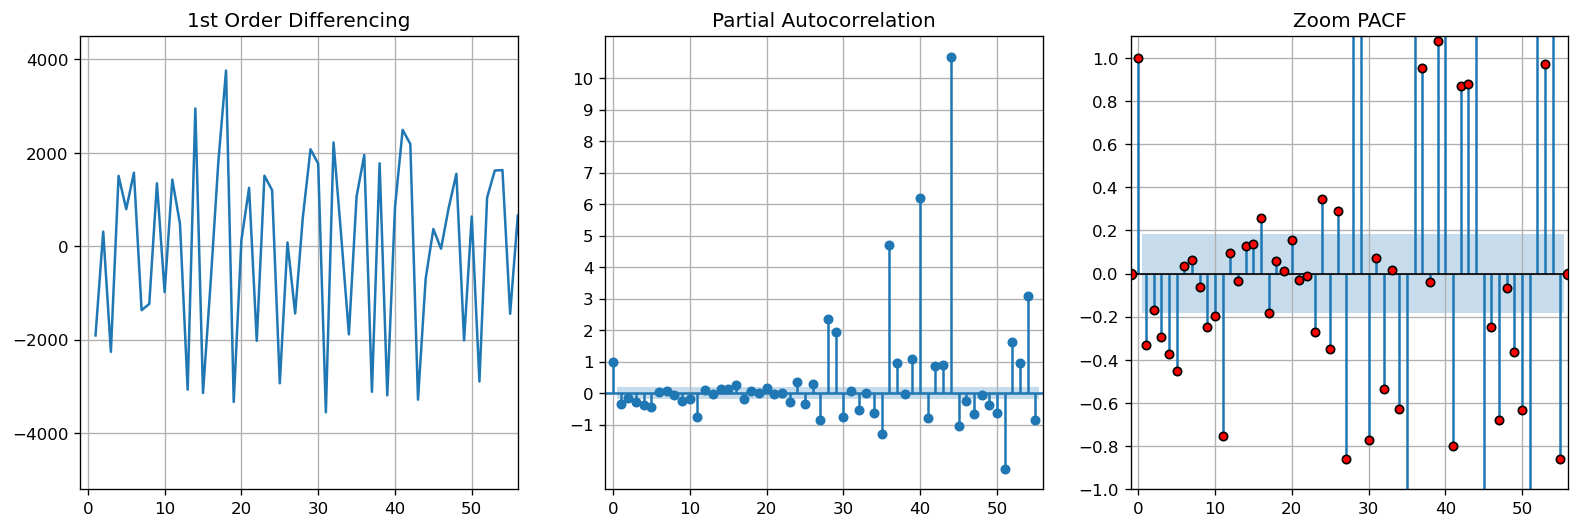

In [32]:
plt.rcParams.update({'figure.figsize':(16,5), 'figure.dpi':120})
# Original Series
fig, axes = plt.subplots(1, 3, sharex=True)
axes[0].plot(data.diff().dropna())
axes[0].set_title('1st Order Differencing')
axes[0].grid()
plot_pacf(data.diff().dropna(), ax=axes[1], use_vlines=True, lags=len(data)/2-2) #compute partial correlations for lags up to 50% of the sample size
axes[1].grid();axes[1].set_yticks(np.arange(-1,11,1));
# 1st Differencing
plot_pacf(data.diff().dropna(), ax=axes[2],use_vlines=True, lags=len(data)/2-2, marker="o",c="k",mfc='r',mec='k',lw=1)
axes[2].grid(); axes[2].set_title('Zoom PACF')
axes[2].set_yticks(np.arange(-1,1.2,0.2));
axes[2].set_ylim(-1,1.1)
axes[2].set_xlim(-1,len(data)/2-1)
plt.savefig('OUTPUTS_FORMATION/P9_91_PACF.jpg',dpi=300)
plt.show()

On fixera l'ordre de l'AR à p=2 (p=3 entre dans le champs de la non-significativité)

### Autocorrelation (ACF) et ordre du MA term (q)

Fonction d'autocorrélation (ACF). Au décalage k, il s'agit de la corrélation entre les valeurs de séries séparées par k intervalles.

L'ACF nous dit combien d'ordres sont nécessaires pour supprimer toute autocorrelation dans les séries stationnaires

Obtention de la relation résiduelle avec les décalages des séries chronologiques dans le graphique ACF.

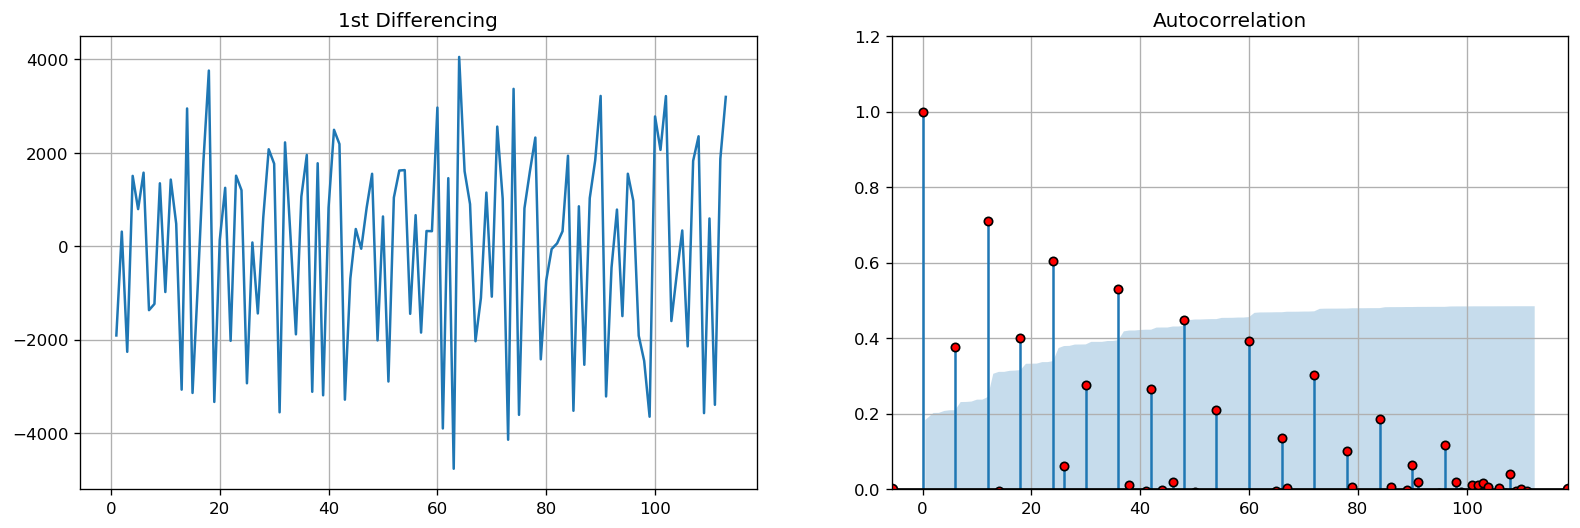

In [33]:
fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(data.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
# plot_acf(data.diff().dropna(), ax=axes[1])
# plot_acf(data, ax=axes[0, 1], lags=len(data)-1,use_vlines=True,missing='drop')
plot_acf(data.diff(), ax=axes[1], lags=len(data.diff().dropna())-1,use_vlines=True,missing='drop', marker="o",c="k",mfc='r',mec='k',lw=1)
axes[0].grid();axes[1].grid()
plt.savefig('OUTPUTS_FORMATION/P9_91_ACF.jpg',dpi=300)
plt.show()

pointe au décalage 1 dans un tracé ACF indique une forte corrélation entre chaque valeur de série et la valeur précédente , 
tandis qu'une pointe au décalage 2 indique une forte corrélation entre chaque valeur et la valeur apparaissant deux points auparavant ...

On fixera l'ordre MA à q=7.

### Préparation modèle SARIMA

#### Détermination des paramètres optimaux pour modèle SARIMA

In [34]:
# Import Packages #
import itertools
import statsmodels.api as sm

# Define the p, d and q parameters to take any value between 0 and 3 (exclusive)
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets (12 in the 's' position as we have monthly data)
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))] 

# Run Grid Search with pdq and seasonal pdq parameters and get the best BIC value #
def sarimax_gridsearch(ts, pdq, pdqs, maxiter=50, freq='M'):                                               
    ans = []
    for comb in pdq:
        for combs in pdqs:
            try:
                mod = sm.tsa.statespace.SARIMAX(ts, # this is your time series you will input
                                                order=comb,
                                                seasonal_order=combs,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)

                output = mod.fit(maxiter=maxiter) 
                ans.append([comb, combs, output.aic, output.bic])
                print('SARIMAX {} x {}12 : AIC Calculated ={}, BIC Calculated ={}'.format(comb, combs, output.aic, output.bic))
            except:
                continue
                                                
    # Convert into dataframe
    ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic', 'bic'])

    # Sort and return top 10 combinations
    ans_df = ans_df.sort_values(by=['bic'],ascending=True)[0:10]
    
    return ans_df

# Apply function to your time series data ###
data_SAR = train_decompose_2['data_corr_T']
data     = decompose['data_corr_T']
# sarimax_gridsearch(data_SAR, pdq, pdqs, maxiter=50,freq='M') #,freq='M'

#### Fit SARIMA

In [35]:
# print('version statmodel',sm.__version__)
from statsmodels.tsa.statespace.sarimax import SARIMAX
my_order = (0,1,1) # p, d, q
my_seasonal_order = (0,1,1,12) # P, D, Q, s  # Good MODEL with Train_2 in gridsearch
# run fit on same train sample as H-W fit
model = SARIMAX(train_decompose_2['data_corr_T'], order=my_order, seasonal_order=my_seasonal_order,
                enforce_stationarity=False, enforce_invertibility=False).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                        data_corr_T   No. Observations:                  102
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -621.429
Date:                            Mon, 04 Oct 2021   AIC                           1248.859
Time:                                    14:52:47   BIC                           1255.811
Sample:                                         0   HQIC                          1251.635
                                            - 102                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7553      0.074    -10.165      0.000      -0.901      -0.610
ma.S.L12      -0.5602      0.111     -5.026      0.000      -0.779      -0.342
sigma2      8.759e+05   1.09e+05      8.067      0.000    6.63e+05    1.09e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 9.44
Prob(Q):                              0.99   Prob(JB):                         0.01
Heteroskedasticity (H):               2.02   Skew:                            -0.63
Prob(H) (two-sided):                  0.09   Kurtosis:                         4.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Analyse du bruit (résidus)

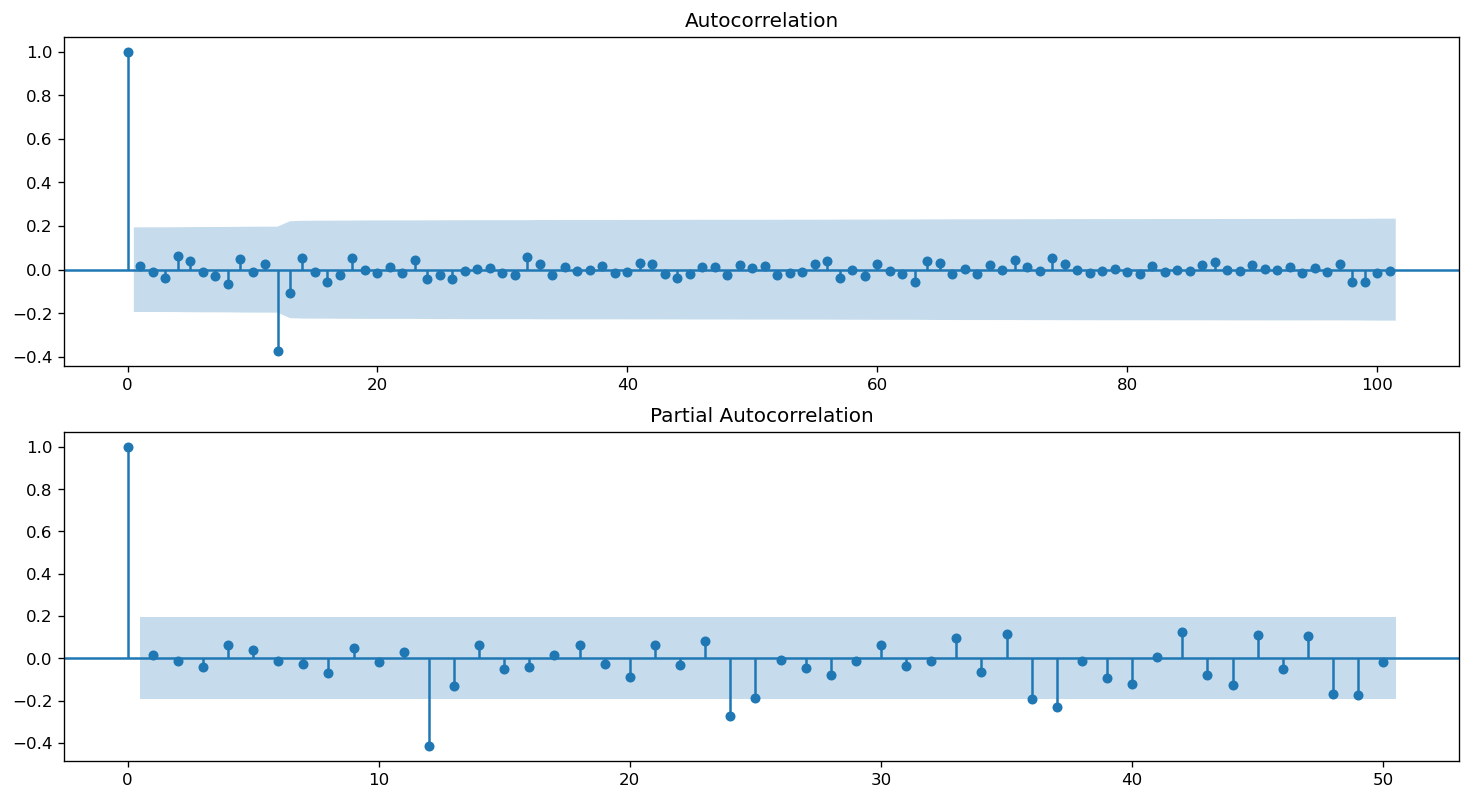

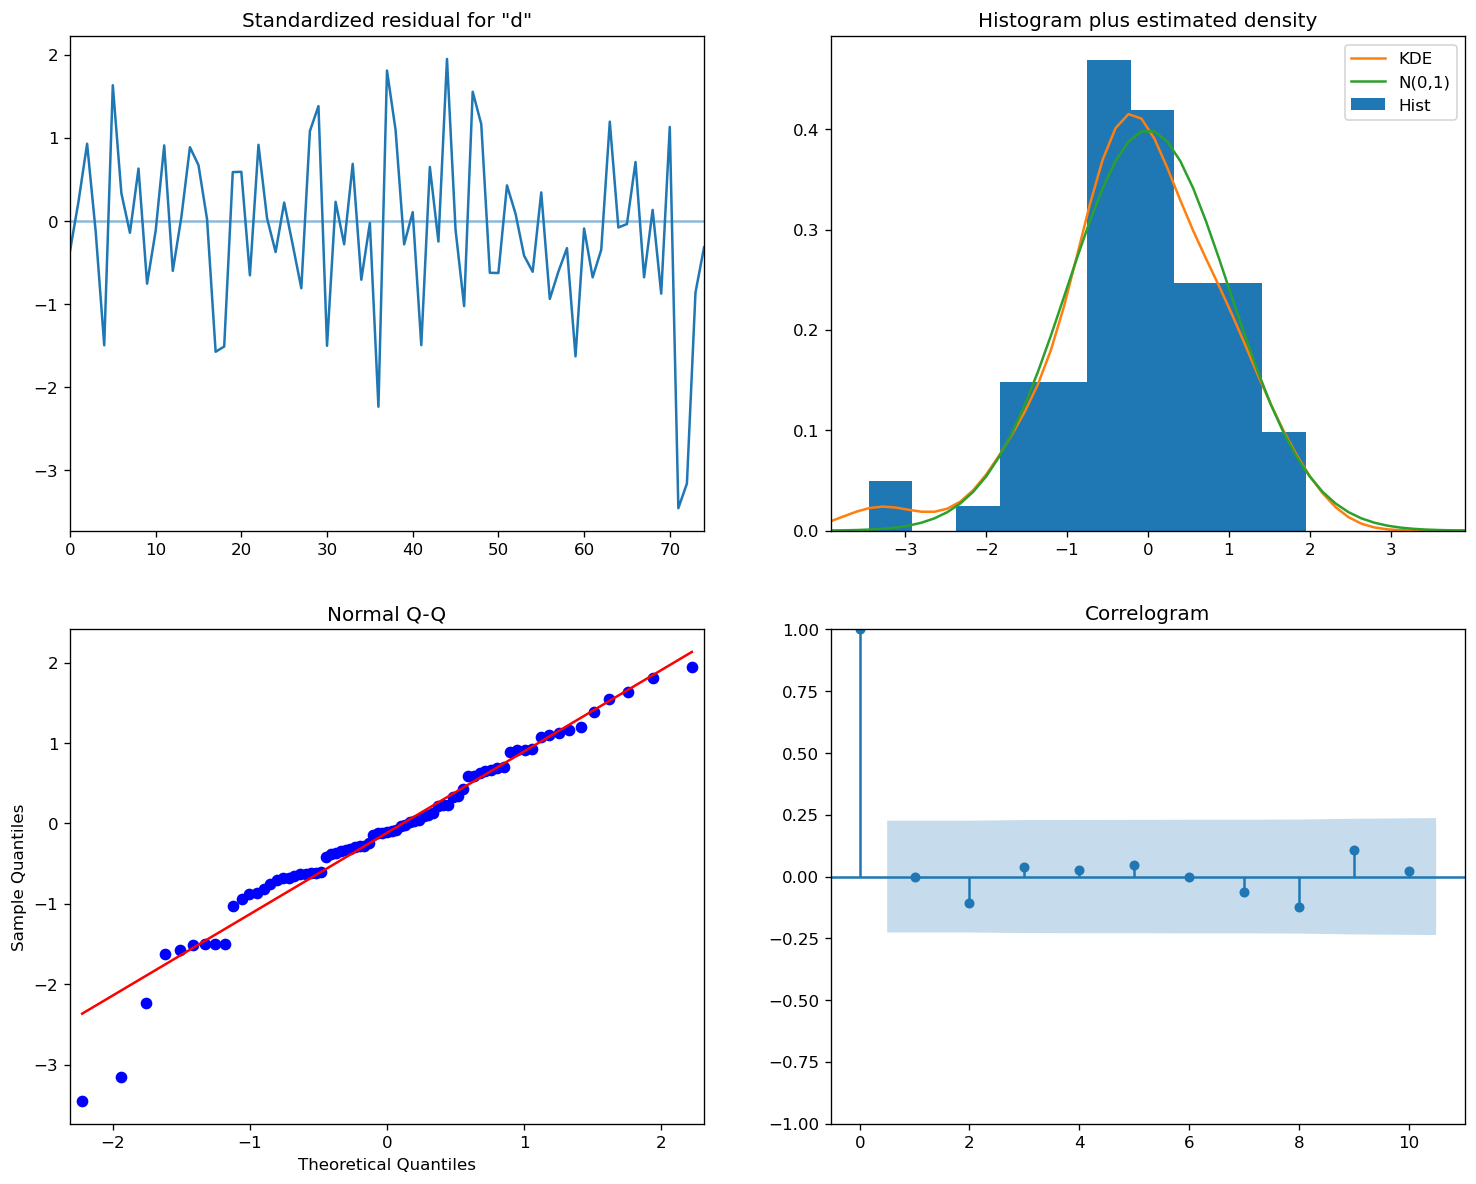

In [36]:
res = model.resid
fig,ax = plt.subplots(2,1,figsize=(15,8))
fig = plot_acf(res, lags=len(data)-13, ax=ax[0])
fig = plot_pacf(res, lags=50, ax=ax[1])
plt.show()

model.plot_diagnostics(figsize=(15, 12))
plt.savefig('OUTPUTS_FORMATION/P9_91_residus_SARIMAX.jpg',dpi=300)
plt.show()

In [37]:
print(st.shapiro(model.resid))

ShapiroResult(statistic=0.38268303871154785, pvalue=9.170201818945292e-19)


In [38]:
# print(sm.stats.acorr_ljungbox(model.resid, return_df=True))
print(sm.stats.acorr_ljungbox(model.resid, lags=[1,2,3,4,5,6,7,8,9,10,11,12], return_df=True))
print('\x1b[6;31;40m',"On ne rejète pas l’hypothèse H0 d’un bruit blanc avec une pvalue > 5%.",'\x1b[0m')
# reject of H0 => residuals are dependent.

      lb_stat  lb_pvalue
1    0.033632   0.854492
2    0.046999   0.976774
3    0.212788   0.975499
4    0.620915   0.960711
5    0.801088   0.976964
6    0.816262   0.991631
7    0.914769   0.996089
8    1.372313   0.994631
9    1.650043   0.995873
10   1.662291   0.998335
11   1.747972   0.999204
12  18.137045   0.111592
 On ne rejète pas l’hypothèse H0 d’un bruit blanc avec une pvalue > 5%. 


## Comparaison des 2 méthodes (HW vs SARIMA)

### Visualisation des 2 méthodes de prédiction

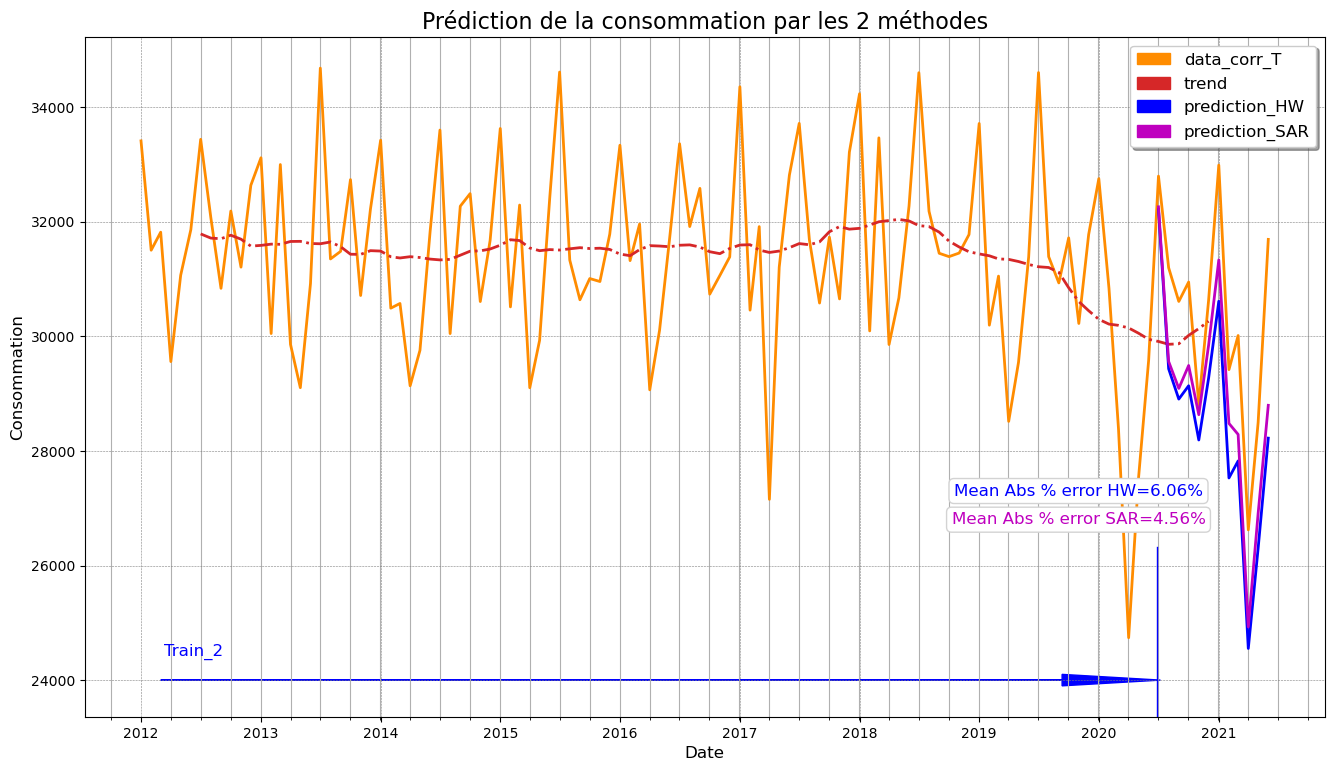

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(16, 9), dpi=100)
indexes = decompose.set_index(pd.to_datetime(g.index))
ax.plot(indexes.index, decompose['data_corr_T'] ,lw=2, c='darkorange',   ls='-')
ax.plot(indexes.index, decompose["trend"]       ,lw=2, c='tab:red', ls='-.')
ax.plot(indexes.index[102:], prediction_2       ,lw=2, c='b',   ls='-')
ax.plot(indexes.index[102:], model.forecast(12) ,lw=2, c='m',   ls='-')

ax.set_title("Prédiction de la consommation par les 2 méthodes",fontsize=16)
my_colors = {"data_corr_T":'darkorange',"trend":'tab:red', "prediction_HW":'b', "prediction_SAR":'m' }          
lab_col = list(my_colors.keys())
handles = [plt.Rectangle((0,0),0,0, color=my_colors[label]) for label in lab_col]              
ax.legend(handles, lab_col, ncol=1, shadow=True, loc='best',fontsize=12)
ax.set_xlabel("Date",fontsize=12)
ax.set_ylabel("Consommation",fontsize=12)
ax.xaxis.set_minor_locator(minor_locator)
ax.grid(color='gray', linestyle='--', linewidth=0.4)
ax.grid(which='minor')
MAPE_pred_HW = mean_absolute_percentage_error(test_decompose_2['data_corr_T'],prediction_2).round(2)
MAPE_pred_SAR = mean_absolute_percentage_error(test_decompose_2['data_corr_T'],model.forecast(12)).round(2)
myString_1 = str("Mean Abs % error HW="+str(MAPE_pred_HW)+"%")
myString_2 = str("Mean Abs % error SAR="+str(MAPE_pred_SAR)+"%")
ax.text(1.82e4, 2.73e4, myString_1 ,color='b', size=12, rotation=0.,ha="center", va="center",bbox=dict(facecolor='w',edgecolor='lightgray', alpha=1, boxstyle="round"))
ax.text(1.82e4, 2.68e4, myString_2 ,color='m', size=12, rotation=0.,ha="center", va="center",bbox=dict(facecolor='w',edgecolor='lightgray', alpha=1, boxstyle="round"))
ax.text(1.55e4, 2.45e4, 'Train_2' ,color='b', size=12, rotation=0.,ha="center", va="center")
ax.arrow(1.54e4, 2.4e4, 2750, 0, head_width=200, width=0.01, ec ='b', fc ='b')
ax.axvline(x=1.844e4, c='b', ymin=0, ymax=.25,lw=1)
plt.savefig('OUTPUTS_FORMATION/P9_91_prediction_HWvSAR.jpg',dpi=300)
plt.show()

### Comparaison Metrics

In [40]:
prediction_HW      = prediction_2.copy()
prediction_SARIMAX = model.forecast(12)

# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(forecast))  # MAPE
    me   = np.mean(forecast - actual)             # ME
    mae  = np.mean(np.abs(forecast - actual))     # MAE
    mpe  = np.mean((forecast - actual)/actual)    # MPE
    rmse = np.mean((forecast - actual)**2)**.5    # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]     # corr
#     mins = np.amin(np.hstack([forecast[:,None], actual[:,None]]), axis=1)
#     maxs = np.amax(np.hstack([forecast[:,None], actual[:,None]]), axis=1)
#     minmax = 1 - np.mean(mins/maxs)               # minmax
#     acf1 = acf(fc-test)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 'mpe': mpe, 'rmse':rmse, #'acf1':acf1,'minmax':minmax,
            'corr':corr})

d1 = forecast_accuracy(test_decompose_2['data_corr_T'].values,prediction_HW.values)
d2 = forecast_accuracy(test_decompose_2['data_corr_T'].values,prediction_SARIMAX.values)

df_metrics_HW = pd.DataFrame({'prediction_HW': d1}).round(4)
df_metrics_SAR = pd.DataFrame({'prediction_SARIMAX': d2}).round(4)
df_metrics = df_metrics_HW.join(df_metrics_SAR)
df_metrics

,prediction_HW,prediction_SARIMAX
corr,0.9190,0.9289
mae,1835.4419,1383.8168
mape,0.0606,0.0456
me,1835.4419,1383.8168
mpe,0.0653,0.0484
rmse,1979.1741,1538.8902


### Prédiction à postériori (année n+1)

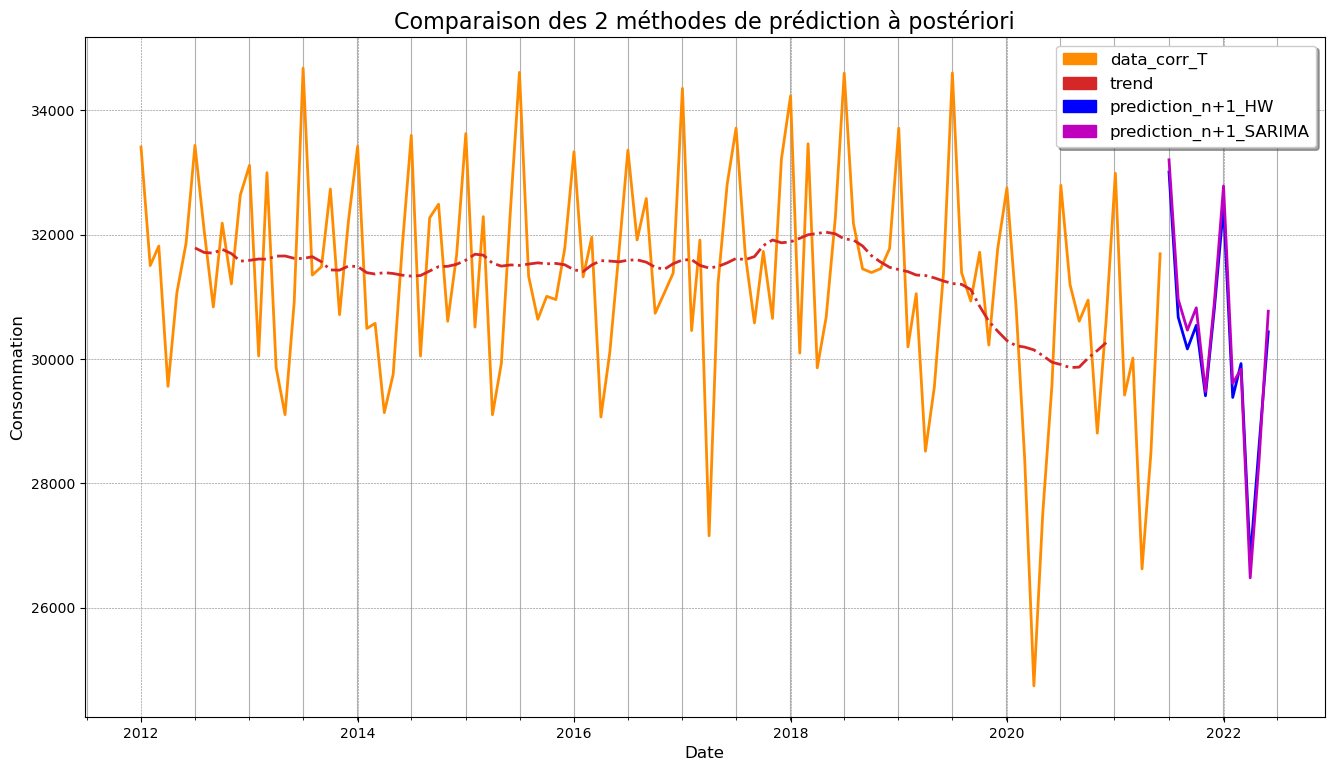

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(16, 9), dpi=100)

y=('2021-07-01', '2021-08-01', '2021-09-01', '2021-10-01','2021-11-01', '2021-12-01',
   '2022-01-01', '2022-02-01', '2022-03-01', '2022-04-01','2022-05-01', '2022-06-01',
#         '2022-07-01', '2022-08-01', '2022-09-01', '2022-10-01','2022-11-01', '2022-12-01',
#         '2023-01-01', '2023-02-01', '2023-03-01', '2023-04-01','2023-05-01', '2023-06-01',  
#             '2023-07-01', '2023-08-01', '2023-09-01', '2023-10-01','2023-11-01', '2023-12-01',
#             '2024-01-01', '2024-02-01', '2024-03-01', '2024-04-01','2024-05-01', '2024-06-01',
#                 '2024-07-01', '2024-08-01', '2024-09-01', '2024-10-01','2024-11-01', '2024-12-01',
#                 '2025-01-01', '2025-02-01', '2025-03-01', '2025-04-01','2025-05-01', '2025-06-01'
  )
ind_2022 = pd.to_datetime(y)

model_post_HW = ExponentialSmoothing(decompose['data_corr_T'],trend='add',seasonal='add',seasonal_periods=12).fit()
pred_np1_HW   = model_post_HW.forecast(len(y))

# rappel des paramètres du modèle validé
# my_order          = (0,2,1) # p, d, q
# my_seasonal_order = (1,2,2,12) # P, D, Q, s  # Good MODEL with all_DATA in gridsearch
my_order = (0,1,1) # p, d, q
my_seasonal_order = (0,1,1,12) # P, D, Q, s  # Good MODEL with Train_2 in gridsearch
model_post_SAR = SARIMAX(decompose['data_corr_T'], order=my_order, seasonal_order=my_seasonal_order,
                         enforce_stationarity=False, enforce_invertibility=False).fit()
pred_np1_SAR   = model_post_SAR.forecast(len(y))

ax.plot(indexes.index, decompose['data_corr_T'],lw=2, c='darkorange',   ls='-')
ax.plot(indexes.index, decompose["trend"]       ,lw=2, c='tab:red',ls='-.')
ax.plot(ind_2022, pred_np1_HW ,lw=2, c='b',ls='-')
ax.plot(ind_2022, pred_np1_SAR,lw=2, c='m',ls='-')
ax.set_title("Comparaison des 2 méthodes de prédiction à postériori",fontsize=16)
my_colors = {"data_corr_T":'darkorange',"trend":'tab:red', "prediction_n+1_HW":'b' , "prediction_n+1_SARIMA":'m' } 
lab_col = list(my_colors.keys())
handles = [plt.Rectangle((0,0),0,0, color=my_colors[label]) for label in lab_col]              
ax.legend(handles, lab_col, ncol=1, shadow=True, loc='best',fontsize=12)
ax.set_xlabel("Date",fontsize=12)
ax.set_ylabel("Consommation",fontsize=12)
minor_locator = AutoMinorLocator(4)
ax.xaxis.set_minor_locator(minor_locator)
ax.grid(color='gray', linestyle='--', linewidth=0.4)
ax.grid(which='minor')
plt.savefig('OUTPUTS_FORMATION/P9_91_prediction_np1.jpg',dpi=300)
plt.show()

### Add-on : Prédiction sur série tronquée

In [42]:
# suppression de la tendance finale à la hausse
X = g['data_corr_T'][:110]
model = sm.tsa.seasonal_decompose(X, model='additive',
                                        filt=None, 
                                            period=12, 
                                                two_sided=True, 
                                                    extrapolate_trend=0)
decompose_tronc = pd.DataFrame({'data_corr_T': Sample_final["Consommation totale corrigée"][:110].values,
                            'trend': model.trend.values,
                            'seasonal': model.seasonal.values,
                            'resid': model.resid.values})

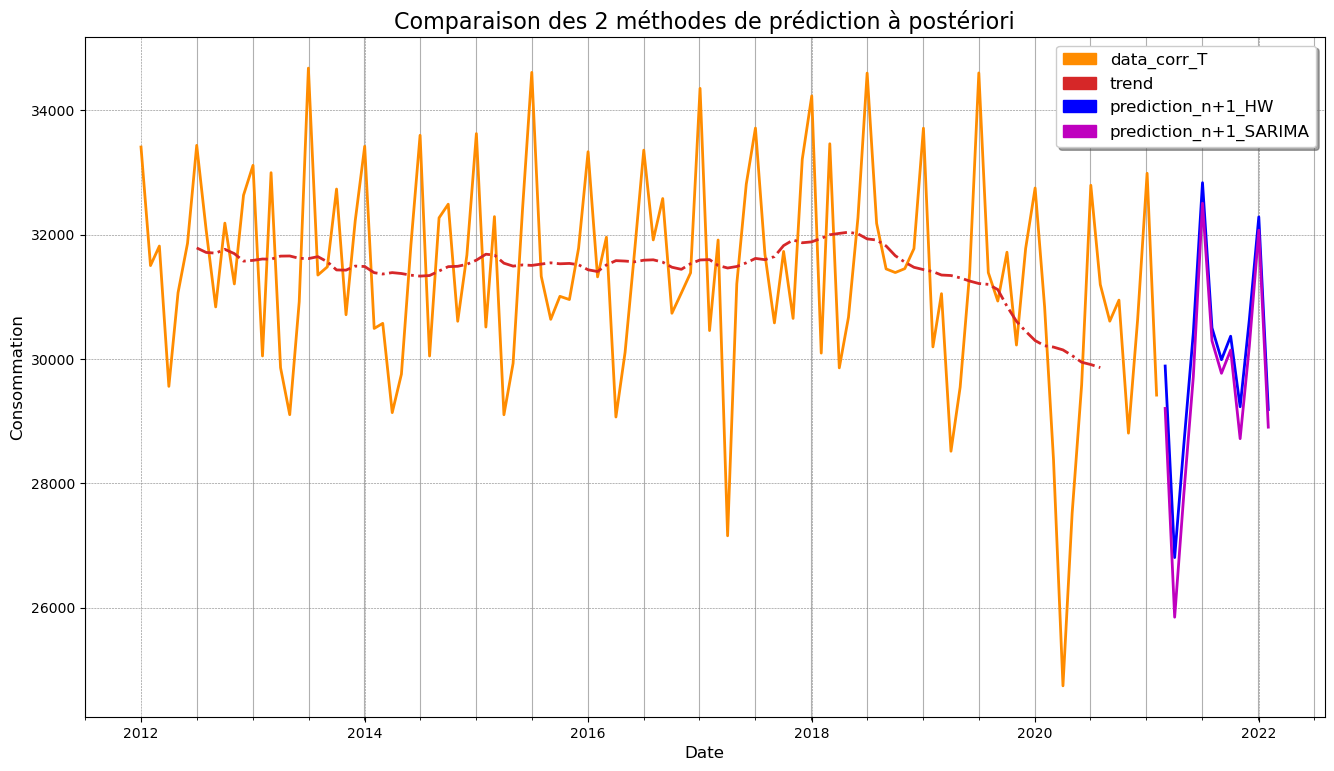

In [43]:
fig, ax = plt.subplots(1, 1, figsize=(16, 9), dpi=100)

y=('2021-03-01', '2021-04-01','2021-05-01', '2021-06-01','2021-07-01', '2021-08-01', 
   '2021-09-01', '2021-10-01','2021-11-01', '2021-12-01','2022-01-01', '2022-02-01',
#    '2022-01-01', '2022-02-01', '2022-03-01', '2022-04-01','2022-05-01', '2022-06-01',
#         '2022-07-01', '2022-08-01', '2022-09-01', '2022-10-01','2022-11-01', '2022-12-01',
#         '2023-01-01', '2023-02-01', '2023-03-01', '2023-04-01','2023-05-01', '2023-06-01',  
#             '2023-07-01', '2023-08-01', '2023-09-01', '2023-10-01','2023-11-01', '2023-12-01',
#             '2024-01-01', '2024-02-01', '2024-03-01', '2024-04-01','2024-05-01', '2024-06-01',
#                 '2024-07-01', '2024-08-01', '2024-09-01', '2024-10-01','2024-11-01', '2024-12-01',
#                 '2025-01-01', '2025-02-01', '2025-03-01', '2025-04-01','2025-05-01', '2025-06-01'
  )
ind_2022 = pd.to_datetime(y)

model_post_HW = ExponentialSmoothing(decompose_tronc['data_corr_T'],trend='add',seasonal='add',seasonal_periods=12).fit()
pred_np1_HW   = model_post_HW.forecast(len(y))

my_order = (0,1,1) # p, d, q
my_seasonal_order = (0,1,1,12) # P, D, Q, s  # Good MODEL with Train_2 in gridsearch
model_post_SAR = SARIMAX(decompose_tronc['data_corr_T'], order=my_order, seasonal_order=my_seasonal_order,
                         enforce_stationarity=False, enforce_invertibility=False).fit()
pred_np1_SAR   = model_post_SAR.forecast(len(y))

ax.plot(indexes[:110].index, decompose_tronc['data_corr_T'],lw=2, c='darkorange',   ls='-')
ax.plot(ind_2022, pred_np1_HW ,lw=2, c='b',ls='-')
ax.plot(ind_2022, pred_np1_SAR,lw=2, c='m',ls='-')
ax.plot(indexes[:110].index, decompose_tronc["trend"]       ,lw=2, c='tab:red',ls='-.')
ax.set_title("Comparaison des 2 méthodes de prédiction à postériori",fontsize=16)
my_colors = {"data_corr_T":'darkorange',"trend":'tab:red', "prediction_n+1_HW":'b' , "prediction_n+1_SARIMA":'m' } 
lab_col = list(my_colors.keys())
handles = [plt.Rectangle((0,0),0,0, color=my_colors[label]) for label in lab_col]              
ax.legend(handles, lab_col, ncol=1, shadow=True, loc='best',fontsize=12)
ax.set_xlabel("Date",fontsize=12)
ax.set_ylabel("Consommation",fontsize=12)
minor_locator = AutoMinorLocator(4)
ax.xaxis.set_minor_locator(minor_locator)
ax.grid(color='gray', linestyle='--', linewidth=0.4)
ax.grid(which='minor')
plt.savefig('OUTPUTS_FORMATION/P9_91_prediction_np1_tronc.jpg',dpi=300)
plt.show()